In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
import math

# Load Dataset

In [2]:
!gdown '1tclfkZMELoYM6LPcSo8qI7e7ubKLC-JL' # train
!gdown '1jtRS7Md3ItW5mUmCUf5eO9aQ_cWez_z6' # test
!gdown '1jUNaufVNHCKBu4KReAyR_-UzoV6lKSnH' # sample_submission

Downloading...
From: https://drive.google.com/uc?id=1tclfkZMELoYM6LPcSo8qI7e7ubKLC-JL
To: /content/train.csv
100% 805k/805k [00:00<00:00, 8.08MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jtRS7Md3ItW5mUmCUf5eO9aQ_cWez_z6
To: /content/test.csv
100% 372k/372k [00:00<00:00, 4.82MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jUNaufVNHCKBu4KReAyR_-UzoV6lKSnH
To: /content/sample_submission.csv
100% 59.9k/59.9k [00:00<00:00, 54.4MB/s]


In [3]:
df1 = pd.read_csv("train.csv")
df1['set'] = 'train'
print('training set:', df1.shape)
df2 = pd.read_csv("test.csv")
df2['set'] = 'test'
print('testing set:', df2.shape)
df = pd.concat([df1, df2], axis=0, ignore_index=True)
print(df.shape)
df.sample(5)

training set: (8693, 15)
testing set: (4277, 14)
(12970, 15)


PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
2415      2592_02       Mars     False    D/75/P  TRAPPIST-1e  18.0  False   
11220     5525_01       Mars     False  F/1142/P          NaN  35.0  False   
7087      7545_01      Earth      True  G/1225/S  TRAPPIST-1e   NaN  False   
5575      5938_02      Earth      True   G/967/S  TRAPPIST-1e   NaN  False   
12396     8062_01      Earth     False  G/1304/S  TRAPPIST-1e  20.0  False   

       RoomService  FoodCourt  ShoppingMall   Spa  VRDeck                Name  \
2415        1102.0        9.0        2628.0   0.0     0.0          Cindee Flé   
11220        221.0       10.0         361.0  16.0     8.0        Widous Kinad   
7087           0.0        0.0           0.0   0.0     0.0  Jasony Nguerrettye   
5575           0.0        0.0           0.0   0.0     0.0  Blancy Floydendley   
12396          4.0        0.0           0.0   0.0   716.0     Maen Shephendry   

      Transported    set  
2415        False  train  
11220         NaN   test  
7087        False  train  
5575         True  train  
12396         NaN   test

# Pre-Processing

- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [4]:
df[['PassengerId_group', 'PassengerId_pp']] = df['PassengerId'].str.split('_', expand=True)
df['PassengerId_group'] = pd.to_numeric(df['PassengerId_group'], errors='coerce', downcast='integer')
df['group_size'] = df['PassengerId_group'].map(df['PassengerId_group'].value_counts())
df[['Cabin_deck', 'Cabin_num', 'Cabin_side']] = df['Cabin'].str.split('/', expand=True)
df['Cabin_num'] = pd.to_numeric(df['Cabin_num'], errors='coerce', downcast='integer')

print(df.shape)
df.head()

(12970, 21)


PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall  ...  VRDeck               Name  \
0          0.0        0.0           0.0  ...     0.0    Maham Ofracculy   
1        109.0        9.0          25.0  ...    44.0       Juanna Vines   
2         43.0     3576.0           0.0  ...    49.0      Altark Susent   
3          0.0     1283.0         371.0  ...   193.0       Solam Susent   
4        303.0       70.0         151.0  ...     2.0  Willy Santantines   

  Transported    set PassengerId_group  PassengerId_pp group_size  Cabin_deck  \
0       False  train                 1              01          1           B   
1        True  train                 2              01          1           F   
2       False  train                 3              01          2           A   
3       False  train                 3              02          2           A   
4        True  train                 4              01          1           F   

  Cabin_num  Cabin_side  
0       0.0           P  
1       0.0           S  
2       0.0           S  
3       0.0           S  
4       1.0           S  

[5 rows x 21 columns]

In [5]:
df.isna().sum()

PassengerId             0
HomePlanet            288
CryoSleep             310
Cabin                 299
Destination           274
Age                   270
VIP                   296
RoomService           263
FoodCourt             289
ShoppingMall          306
Spa                   284
VRDeck                268
Name                  294
Transported          4277
set                     0
PassengerId_group       0
PassengerId_pp          0
group_size              0
Cabin_deck            299
Cabin_num             299
Cabin_side            299
dtype: int64

# EDA

In [6]:
df.dtypes

PassengerId           object
HomePlanet            object
CryoSleep             object
Cabin                 object
Destination           object
Age                  float64
VIP                   object
RoomService          float64
FoodCourt            float64
ShoppingMall         float64
Spa                  float64
VRDeck               float64
Name                  object
Transported           object
set                   object
PassengerId_group      int16
PassengerId_pp        object
group_size             int64
Cabin_deck            object
Cabin_num            float64
Cabin_side            object
dtype: object

## 單變數

In [7]:
continuous_variables = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
discrete_variables = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side', 'group_size']
big_discrete_variables = ['PassengerId_group', 'Cabin_num']

### continuous variables

觀察到離群值很多，很嚴重的右偏，後續可以做log之類的資料轉換。

In [8]:
# 全部資料
df[continuous_variables].describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  12700.000000  12707.000000  12681.000000  12664.000000  12686.000000   
mean      28.771969    222.897852    451.961675    174.906033    308.476904   
std       14.387261    647.596664   1584.370747    590.558690   1130.279641   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       19.000000      0.000000      0.000000      0.000000      0.000000   
50%       27.000000      0.000000      0.000000      0.000000      0.000000   
75%       38.000000     49.000000     77.000000     29.000000     57.000000   
max       79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count  12702.000000  
mean     306.789482  
std     1180.097223  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       42.000000  
max    24133.000000

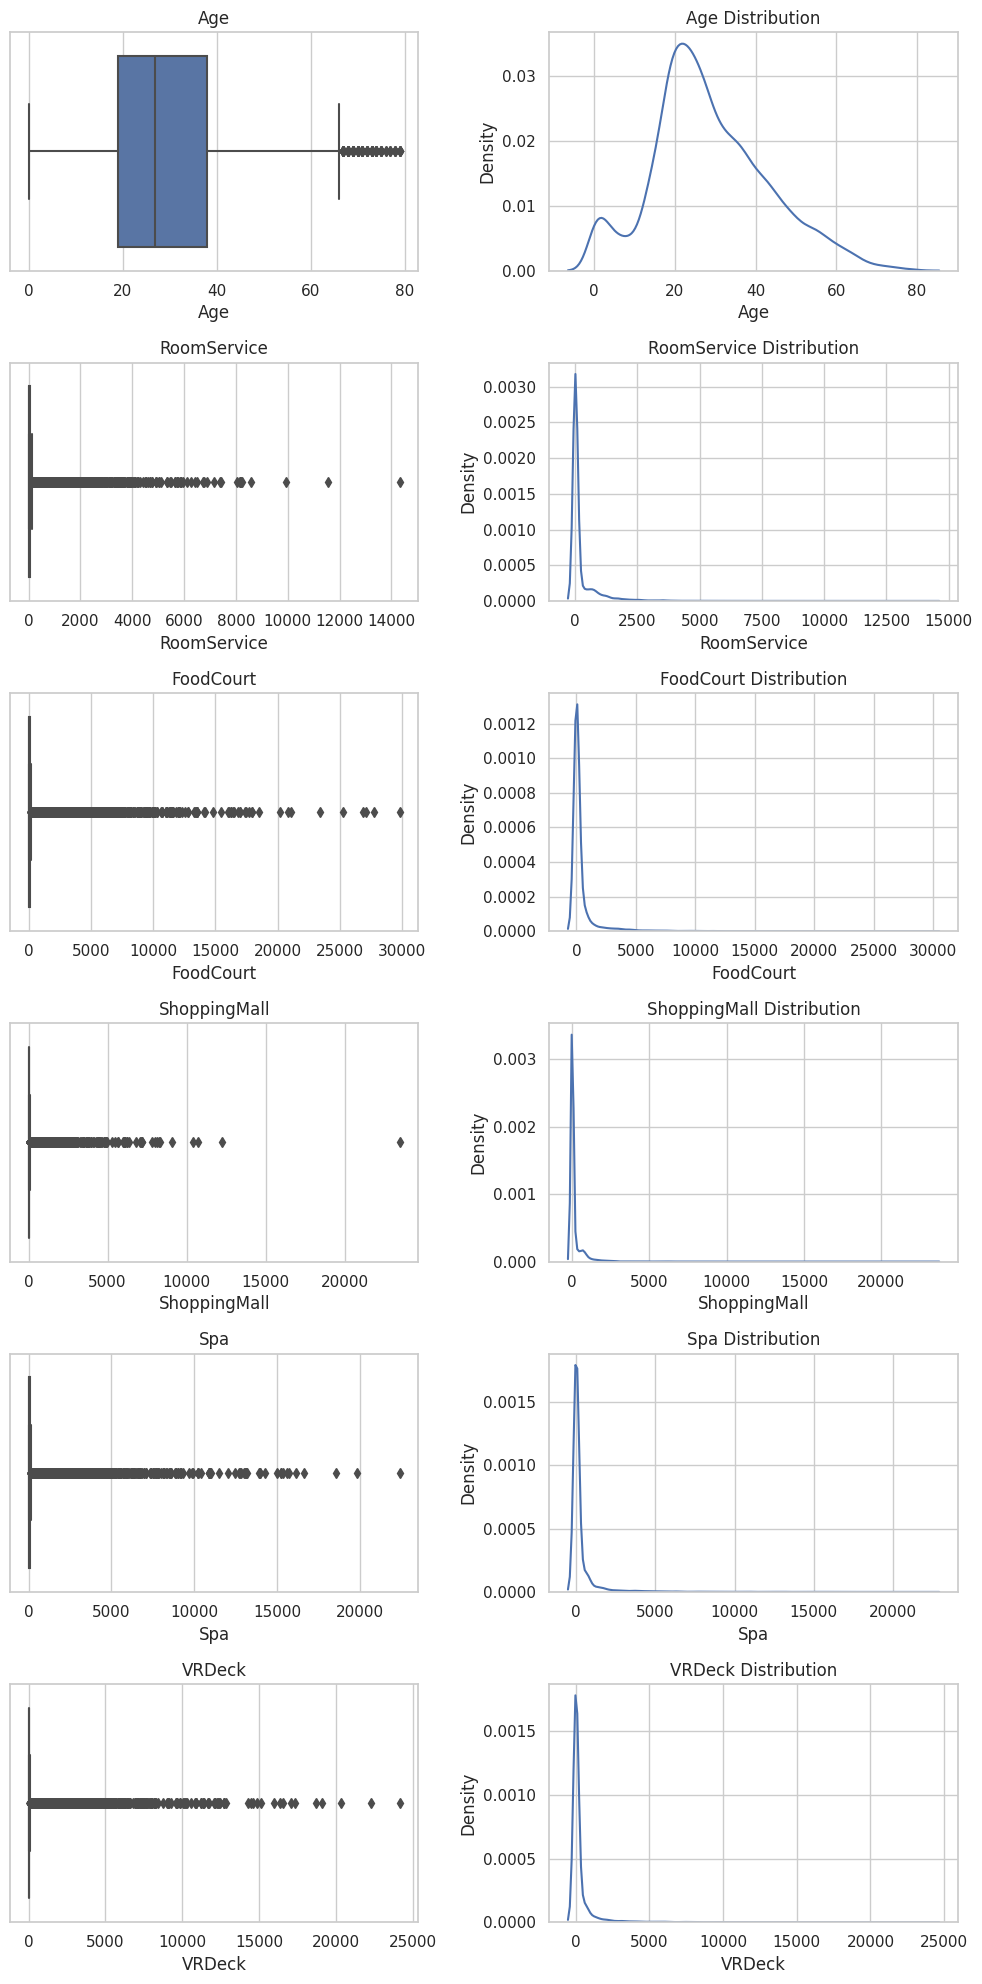

In [9]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=len(continuous_variables), ncols=2, figsize=(10, 20))

for i, variable in enumerate(continuous_variables):

    sns.boxplot(x=variable, data=df, ax=axes[i, 0])
    axes[i, 0].set_title(f'{variable}')

    sns.kdeplot(data=df, x=variable, ax=axes[i, 1])
    axes[i, 1].set_title(f'{variable} Distribution')

plt.tight_layout()
plt.show()

In [10]:
# 分訓練與測試資料觀察
pd.DataFrame(df[continuous_variables+['set']].groupby(by=['set']).describe()).stack().unstack(0)

Age                RoomService                   FoodCourt  \
set           test        train          test         train          test   
count  4186.000000  8514.000000   4195.000000   8512.000000   4171.000000   
mean     28.658146    28.827930    219.266269    224.687617    439.484296   
std      14.179072    14.489021    607.011289    666.717663   1527.663045   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%      19.000000    19.000000      0.000000      0.000000      0.000000   
50%      26.000000    27.000000      0.000000      0.000000      0.000000   
75%      37.000000    38.000000     53.000000     47.000000     78.000000   
max      79.000000    79.000000  11567.000000  14327.000000  25273.000000   

                    ShoppingMall                         Spa                \
set           train         test         train          test         train   
count   8510.000000  4179.000000   8485.000000   4176.000000   8510.000000   
mean     458.077203   177.295525    173.729169    303.052443    311.138778   
std     1611.489240   560.821123    604.696458   1117.186015   1136.705535   
min        0.000000     0.000000      0.000000      0.000000      0.000000   
25%        0.000000     0.000000      0.000000      0.000000      0.000000   
50%        0.000000     0.000000      0.000000      0.000000      0.000000   
75%       76.000000    33.000000     27.000000     50.000000     59.000000   
max    29813.000000  8292.000000  23492.000000  19844.000000  22408.000000   

             VRDeck                
set            test         train  
count   4197.000000   8505.000000  
mean     310.710031    304.854791  
std     1246.994742   1145.717189  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%       36.000000     46.000000  
max    22272.000000  24133.000000

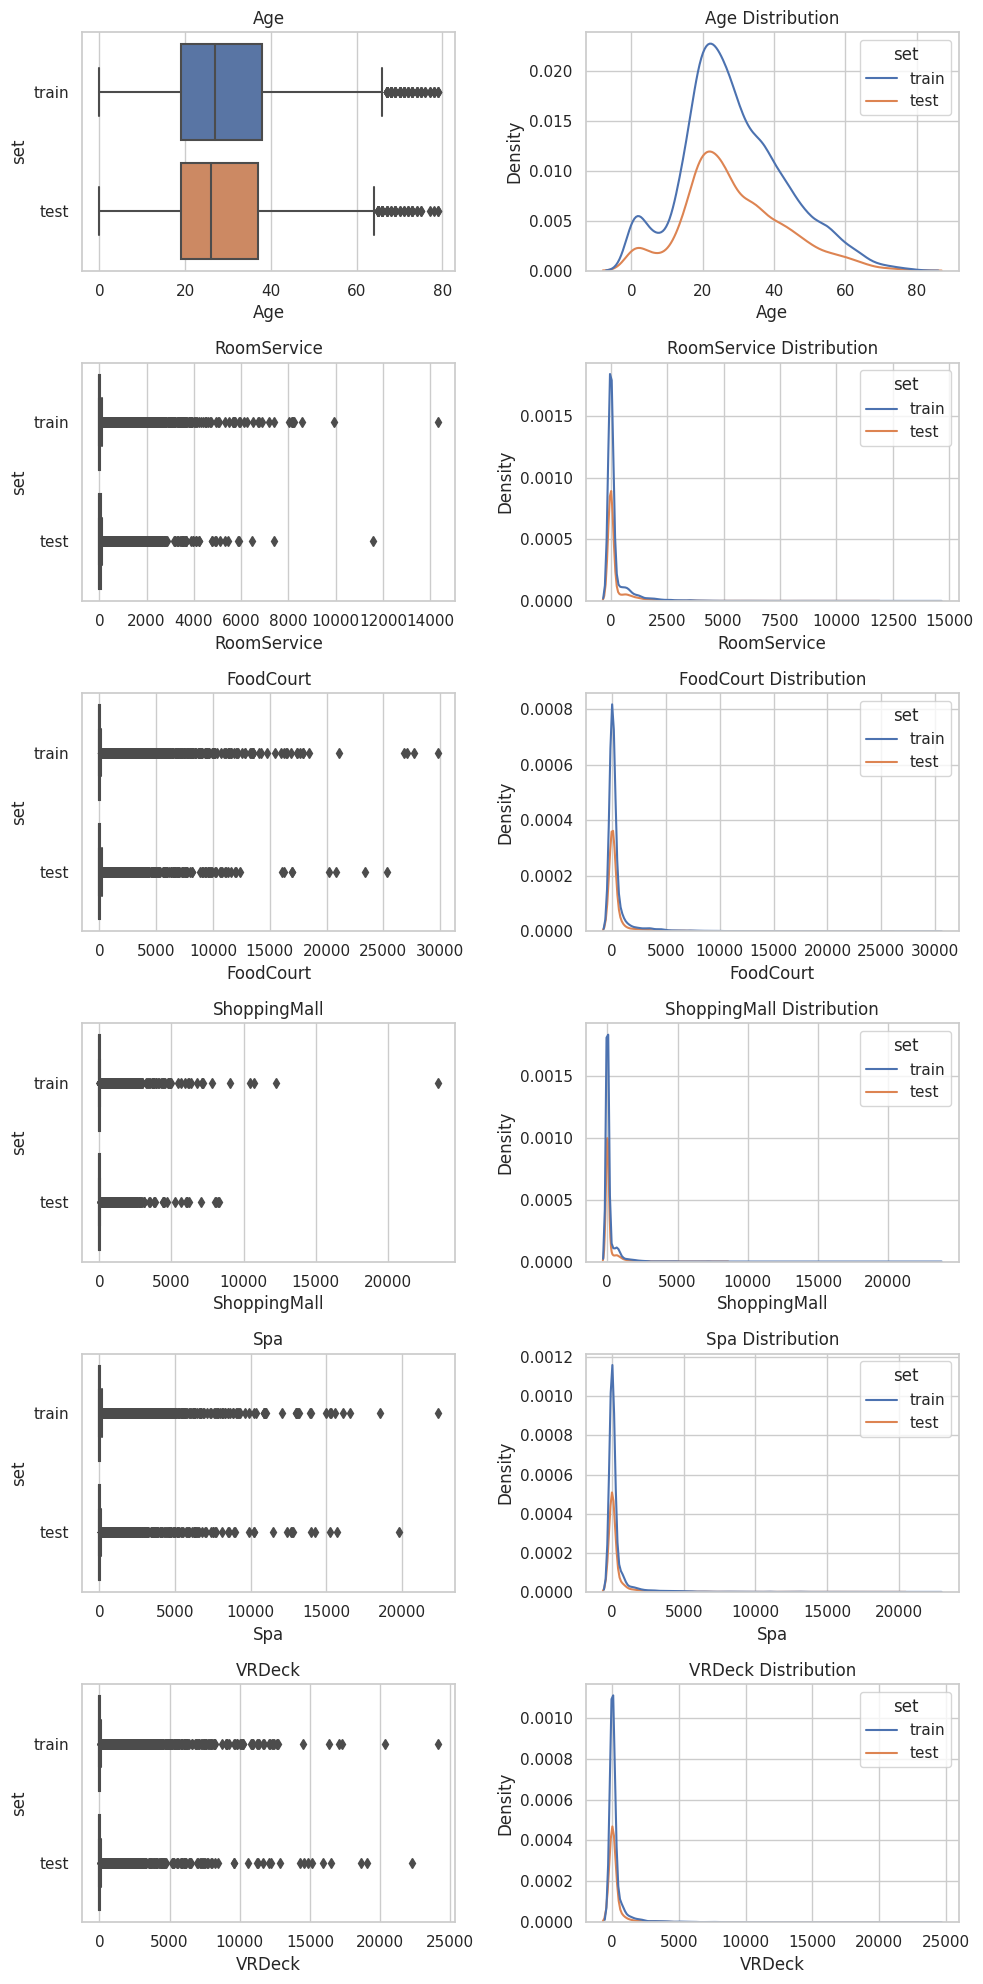

In [11]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=len(continuous_variables), ncols=2, figsize=(10, 20))

for i, variable in enumerate(continuous_variables):

    sns.boxplot(x=variable, y='set', data=df, ax=axes[i, 0])
    axes[i, 0].set_title(f'{variable}')

    sns.kdeplot(data=df, x=variable, hue='set', ax=axes[i, 1])
    axes[i, 1].set_title(f'{variable} Distribution')

plt.tight_layout()
plt.show()

### discrete variables

初步觀察測試資料與訓練資料的分佈不會差太多。

In [ ]:
for var in discrete_variables:
  print(df[var].value_counts())
  print('==========================')

Earth     6865
Europa    3133
Mars      2684
Name: HomePlanet, dtype: int64
False    8079
True     4581
Name: CryoSleep, dtype: int64
TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64
False    12401
True       273
Name: VIP, dtype: int64
F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: Cabin_deck, dtype: int64
S    6381
P    6290
Name: Cabin_side, dtype: int64
1    7145
2    2590
3    1506
4     616
5     380
7     329
6     252
8     152
Name: group_size, dtype: int64


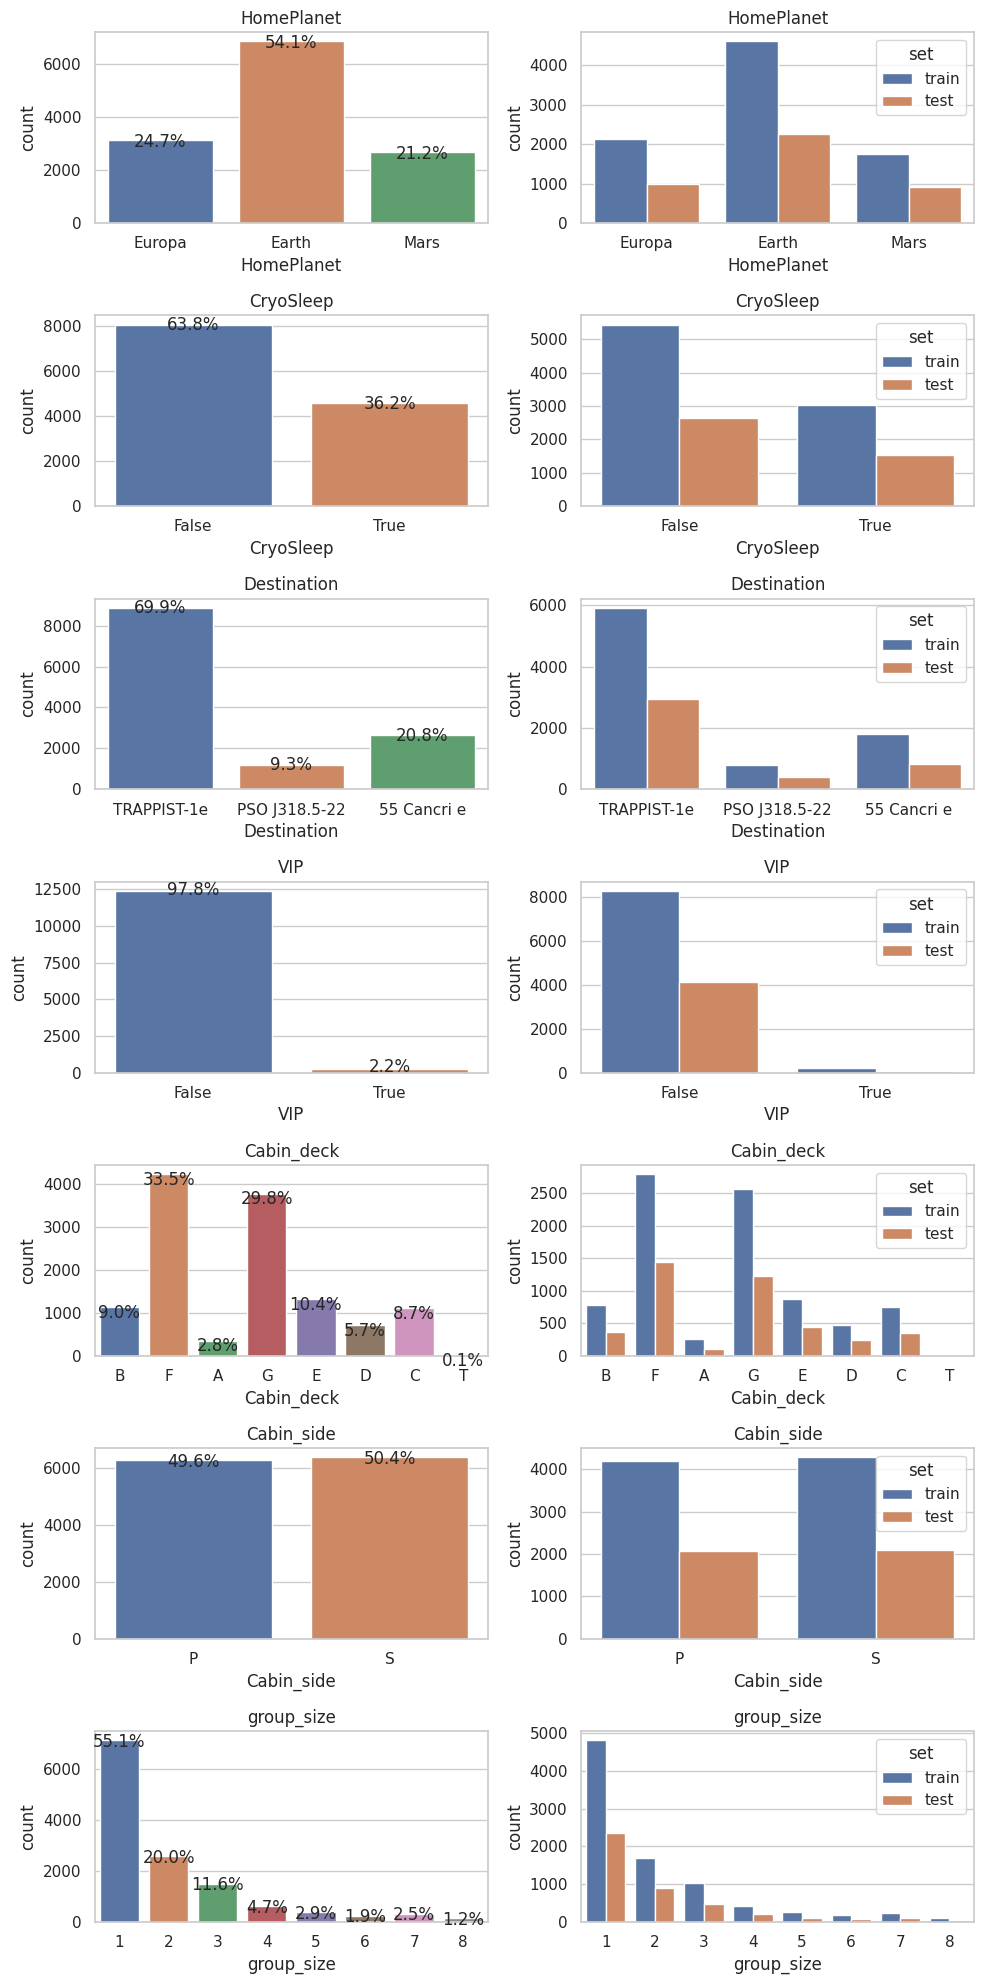

In [ ]:
# 全部&測試訓練集
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=len(discrete_variables), ncols=2, figsize=(10, 20))

for i, variable in enumerate(discrete_variables):

    ax = sns.countplot(x=variable, data=df, ax=axes[i,0])
    axes[i,0].set_title(f'{variable}')

    total = len(df[~df[variable].isna()][variable])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() - 0.02 * total
        ax.text(x, y, percentage, ha='center')

    ax = sns.countplot(x=variable, hue='set', data=df, ax=axes[i,1])
    axes[i,1].set_title(f'{variable}')

plt.tight_layout()
plt.show()

<Axes: xlabel='PassengerId_group', ylabel='count'>

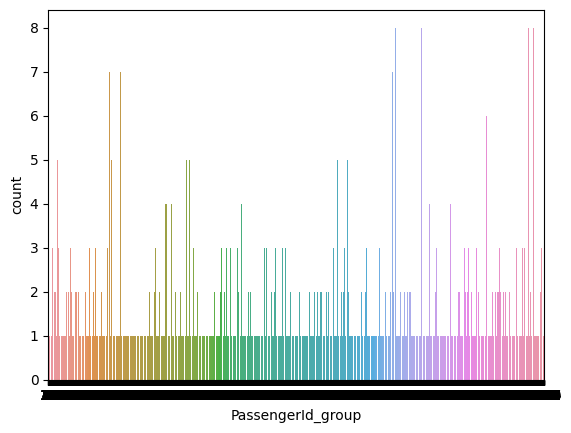

In [ ]:
sns.countplot(x='PassengerId_group', data=df)

<Axes: xlabel='Cabin_num', ylabel='count'>

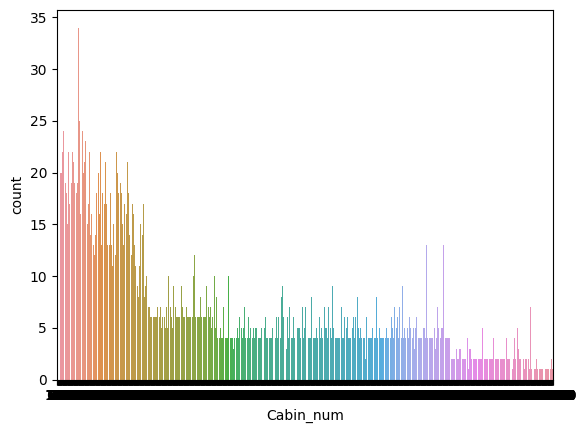

In [ ]:
sns.countplot(x='Cabin_num', data=df)

## 雙變數

### continuous vs continuous

* 連續型變數間彼此有些微相關性
* FoodCourt & RoomService, ShoppingMall & RoomService, Spa & FoodCourt, Spa & ShoppingMall, VRDeck & FoodCourt, VRDeck & ShoppingMall 似乎可以很好的分辨 Transported，且消費較低的人較多 Transported
* 後續可以新增相關變數幫助識別 Transported

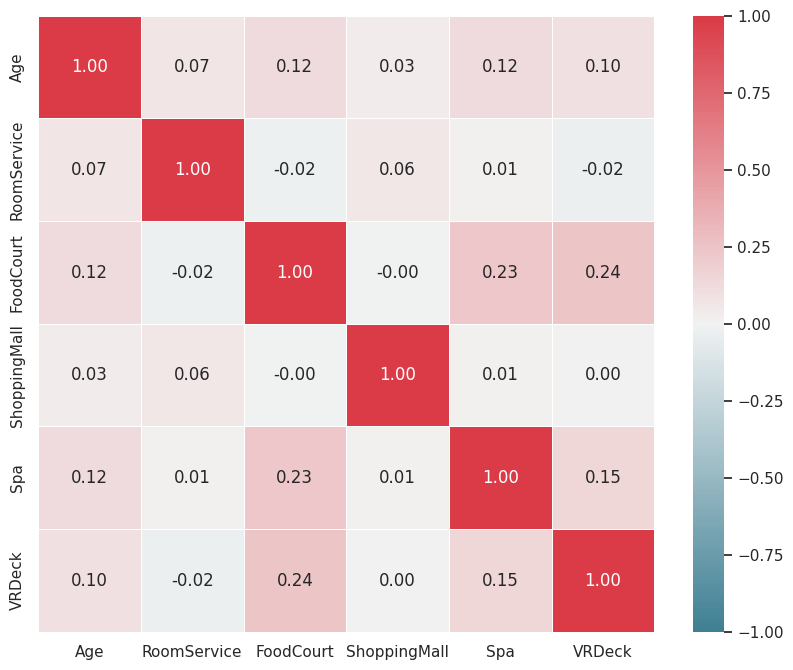

In [ ]:
# pearson相關係數矩陣
f, ax = plt.subplots(figsize=(10,8))
corr = df[continuous_variables].corr(method='pearson')
sns.heatmap(corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, ax=ax,
            annot=True, fmt=".2f", linewidths=.5)
plt.show()

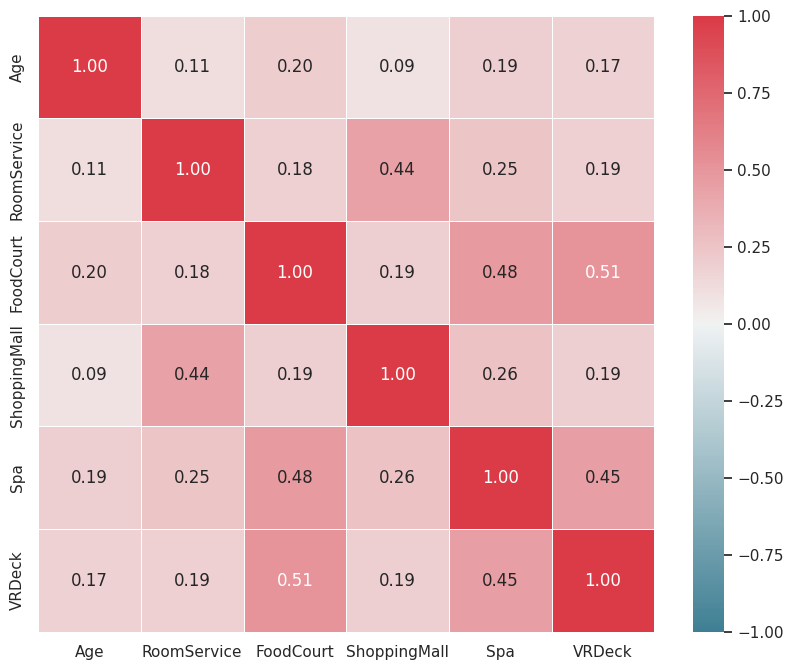

In [ ]:
# spearman相關係數矩陣
f, ax = plt.subplots(figsize=(10,8))
corr = df[continuous_variables].corr(method='spearman')
sns.heatmap(corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, ax=ax,
            annot=True, fmt=".2f", linewidths=.5)
plt.show()

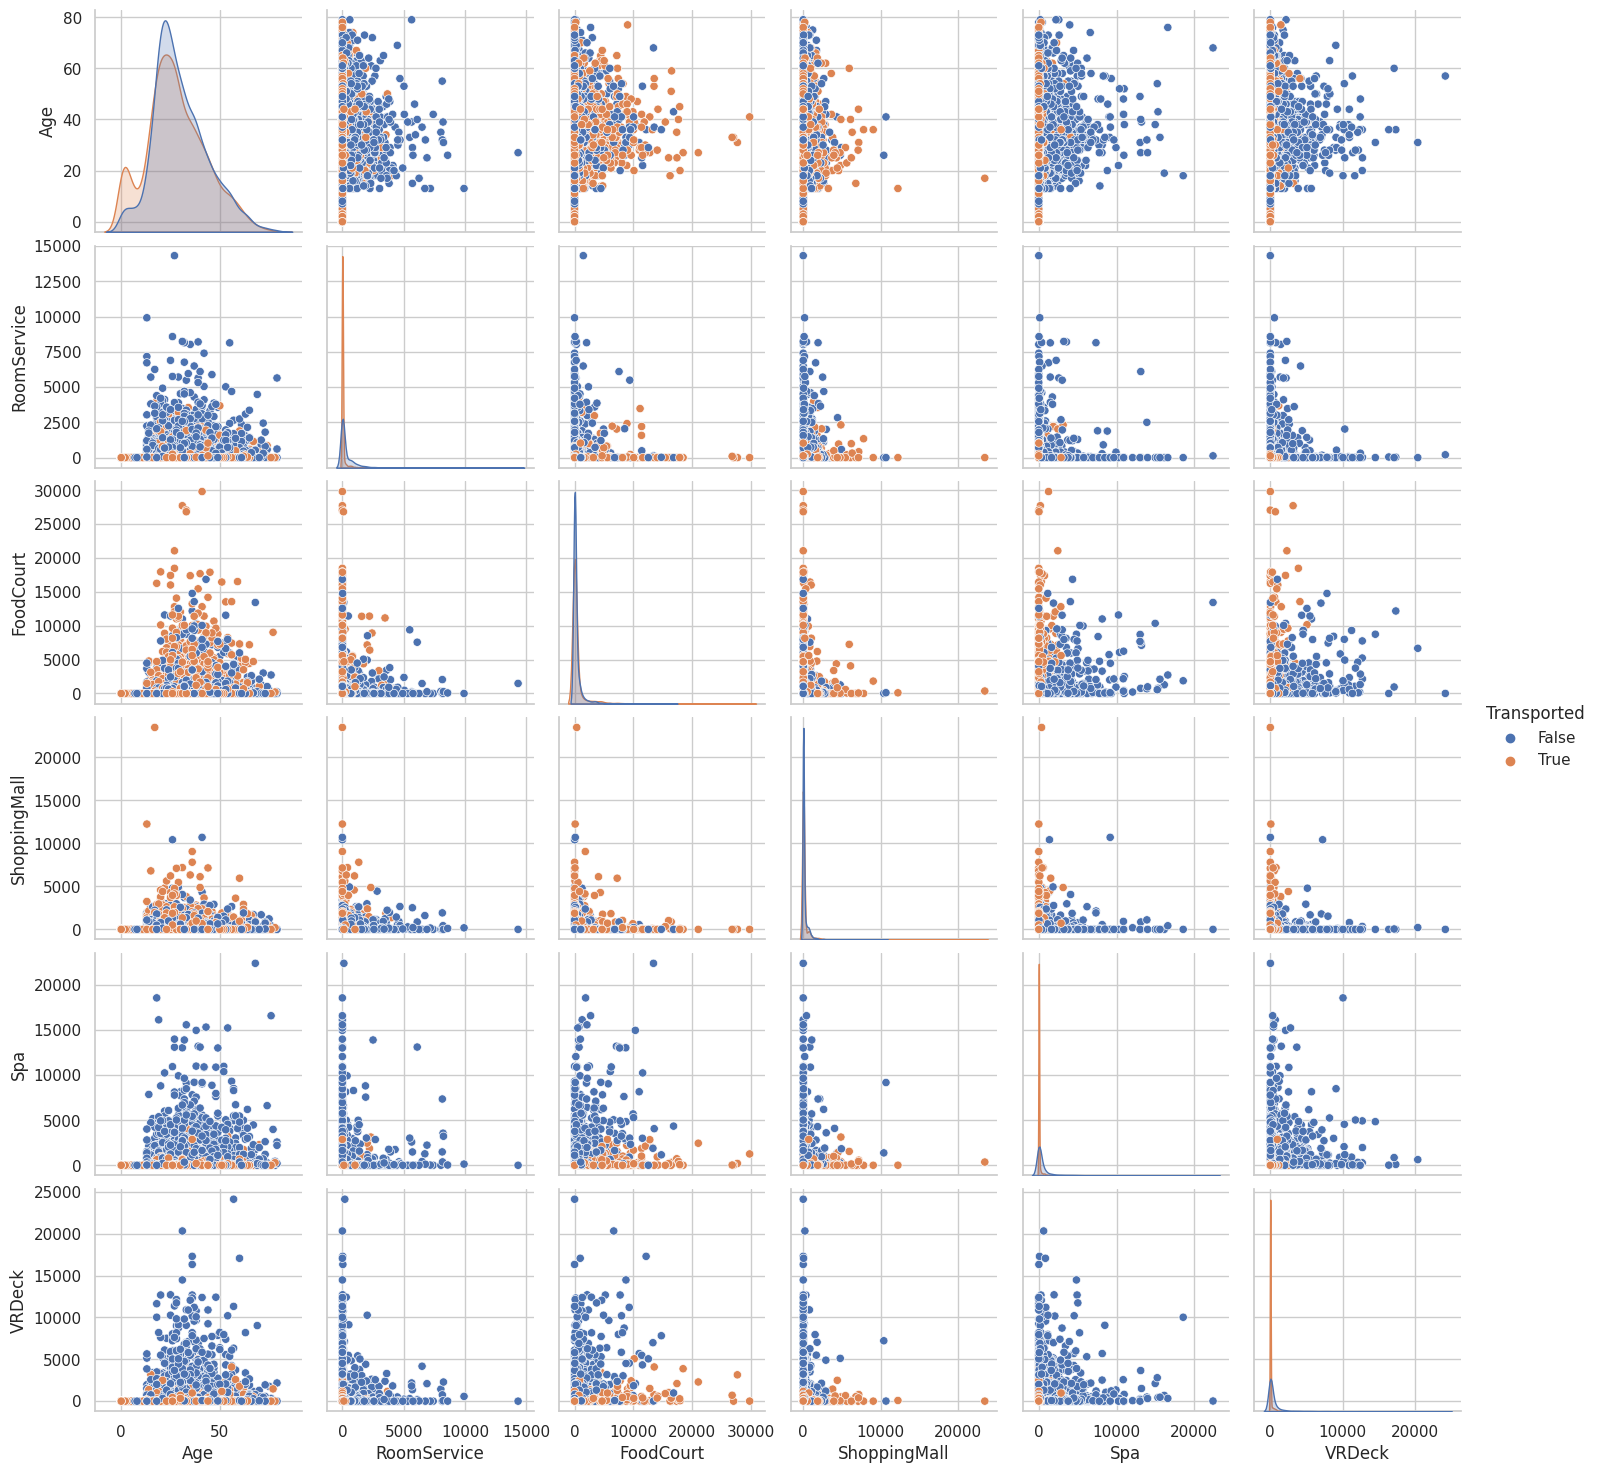

In [ ]:
sns.pairplot(df[df['set']=='train'][continuous_variables+['Transported']], hue='Transported')
plt.show()

### discrete vs discrete

觀察到下列現象，可作為補值的參考：

* Cabin_deck A, B, C, T -> HomePlanet 皆是 Europa
* Cabin_deck G -> HomePlanet Earth
* group_size 8 -> HomePlanet Earth
* Cabin_deck T -> CryoSleep False
* HomePlanet Earth -> VIP False
* Cabin_deck T -> VIP False
* group_size 8 -> VIP False

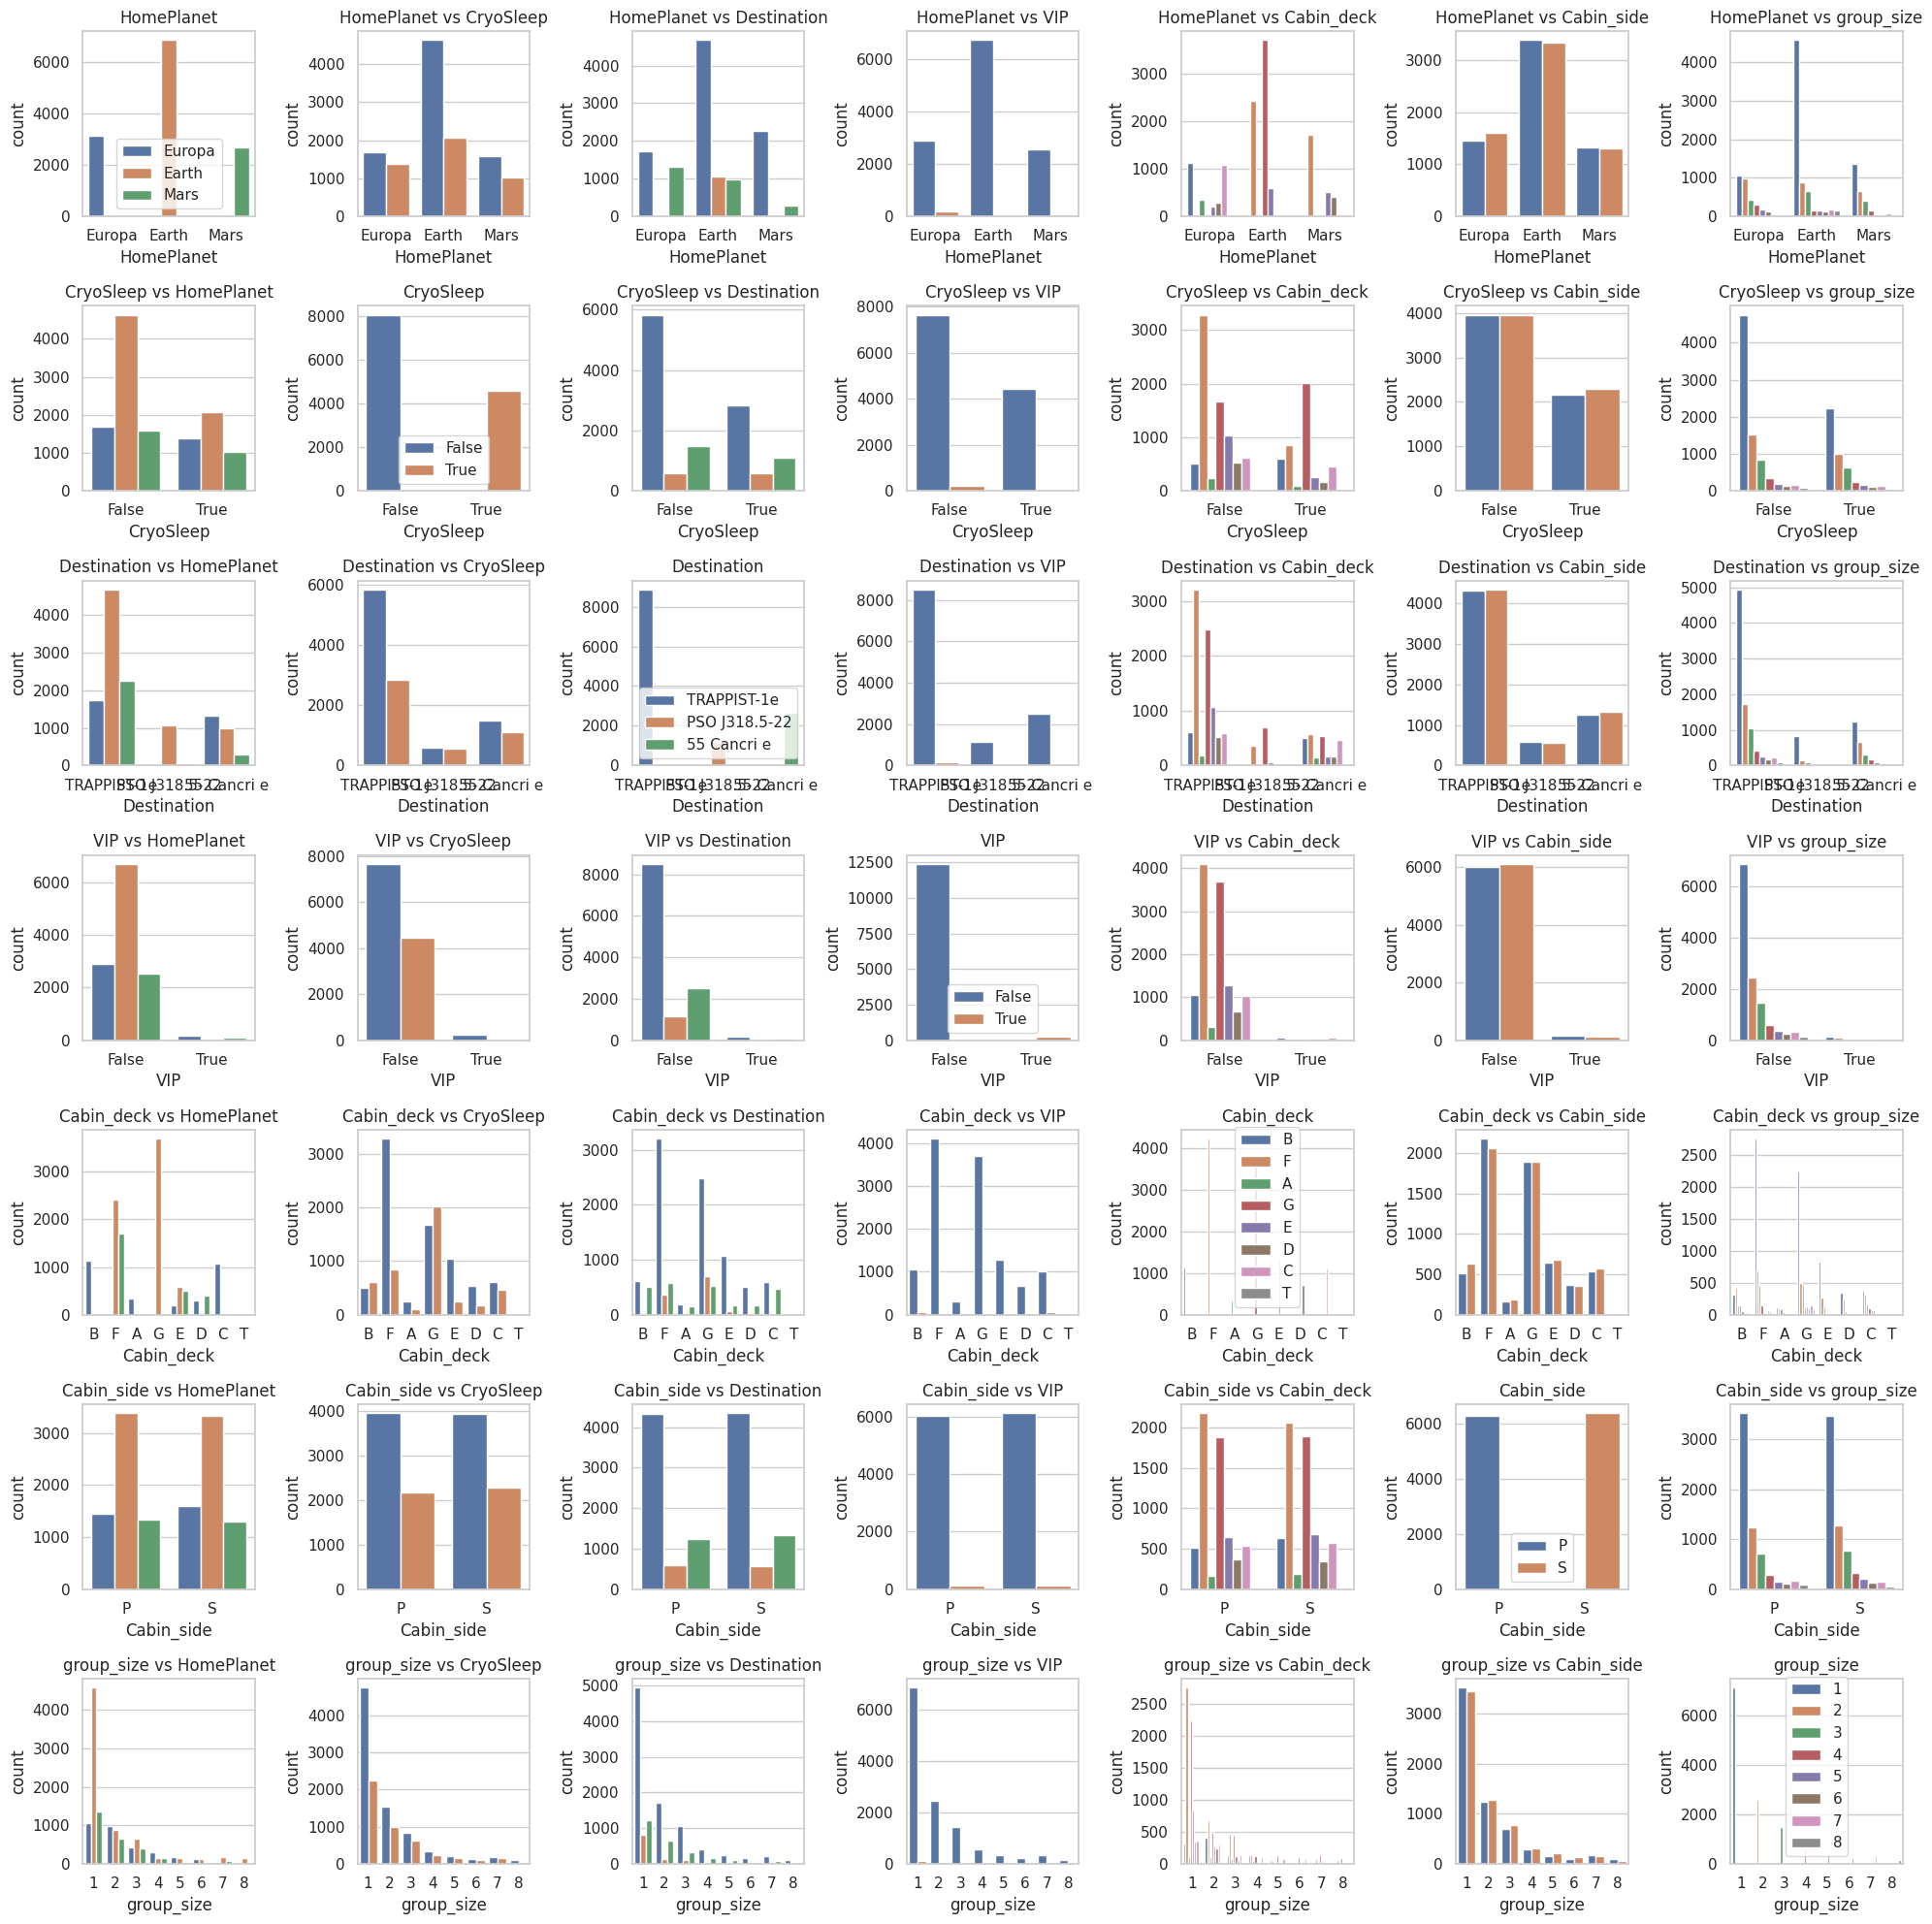

In [ ]:
# 每張圖往上下列看可以照到圖例

fig, axes = plt.subplots(nrows=len(discrete_variables), ncols=len(discrete_variables), figsize=(20,20))

for i, variable_i in enumerate(discrete_variables):
  for j, variable_j in enumerate(discrete_variables):
    if i==j:
      ax = sns.countplot(x=variable_i, hue=variable_j, data=df, ax=axes[i,j])
      axes[i,j].set_title(f'{variable_i}')
      axes[i,j].legend(loc='lower center')
    else:
      ax = sns.countplot(x=variable_i, hue=variable_j, data=df, ax=axes[i,j])
      ax.get_legend().remove()
      axes[i,j].set_title(f'{variable_i} vs {variable_j}')

plt.tight_layout()
plt.show()

In [ ]:
for variable_i in discrete_variables:
  for variable_j in discrete_variables:
    if variable_i != variable_j:
      print(df.groupby(variable_j)[variable_i].value_counts(sort=False, dropna=False))
      print('======================')

CryoSleep  HomePlanet
False      NaN            180
           Earth         4632
           Europa        1678
           Mars          1589
True       NaN            103
           Earth         2070
           Europa        1374
           Mars          1034
Name: HomePlanet, dtype: int64
Destination    HomePlanet
55 Cancri e    NaN             53
               Earth          984
               Europa        1310
               Mars           294
PSO J318.5-22  NaN             23
               Earth         1065
               Europa          29
               Mars            67
TRAPPIST-1e    NaN            206
               Earth         4672
               Europa        1737
               Mars          2256
Name: HomePlanet, dtype: int64
VIP    HomePlanet
False  NaN            279
       Earth         6706
       Europa        2883
       Mars          2533
True   NaN              6
       Europa         177
       Mars            90
Name: HomePlanet, dtype: int64
Cabin_deck 

### continuous vs discrete

觀察到下列現象，可作為補值的參考：

* HomePlanet Europa 的人，普遍消費金額較高
* CryoSleep True -> 不會有任何消費，RoomService, FoodCourt, ShoppingMall, Spa, VRDeck 皆為0
* Destination 55 Cancri e 的人，普遍消費能力較高
* VIP True 的人，普遍消費金額較高
* group_size 越大，似乎消費金額越低

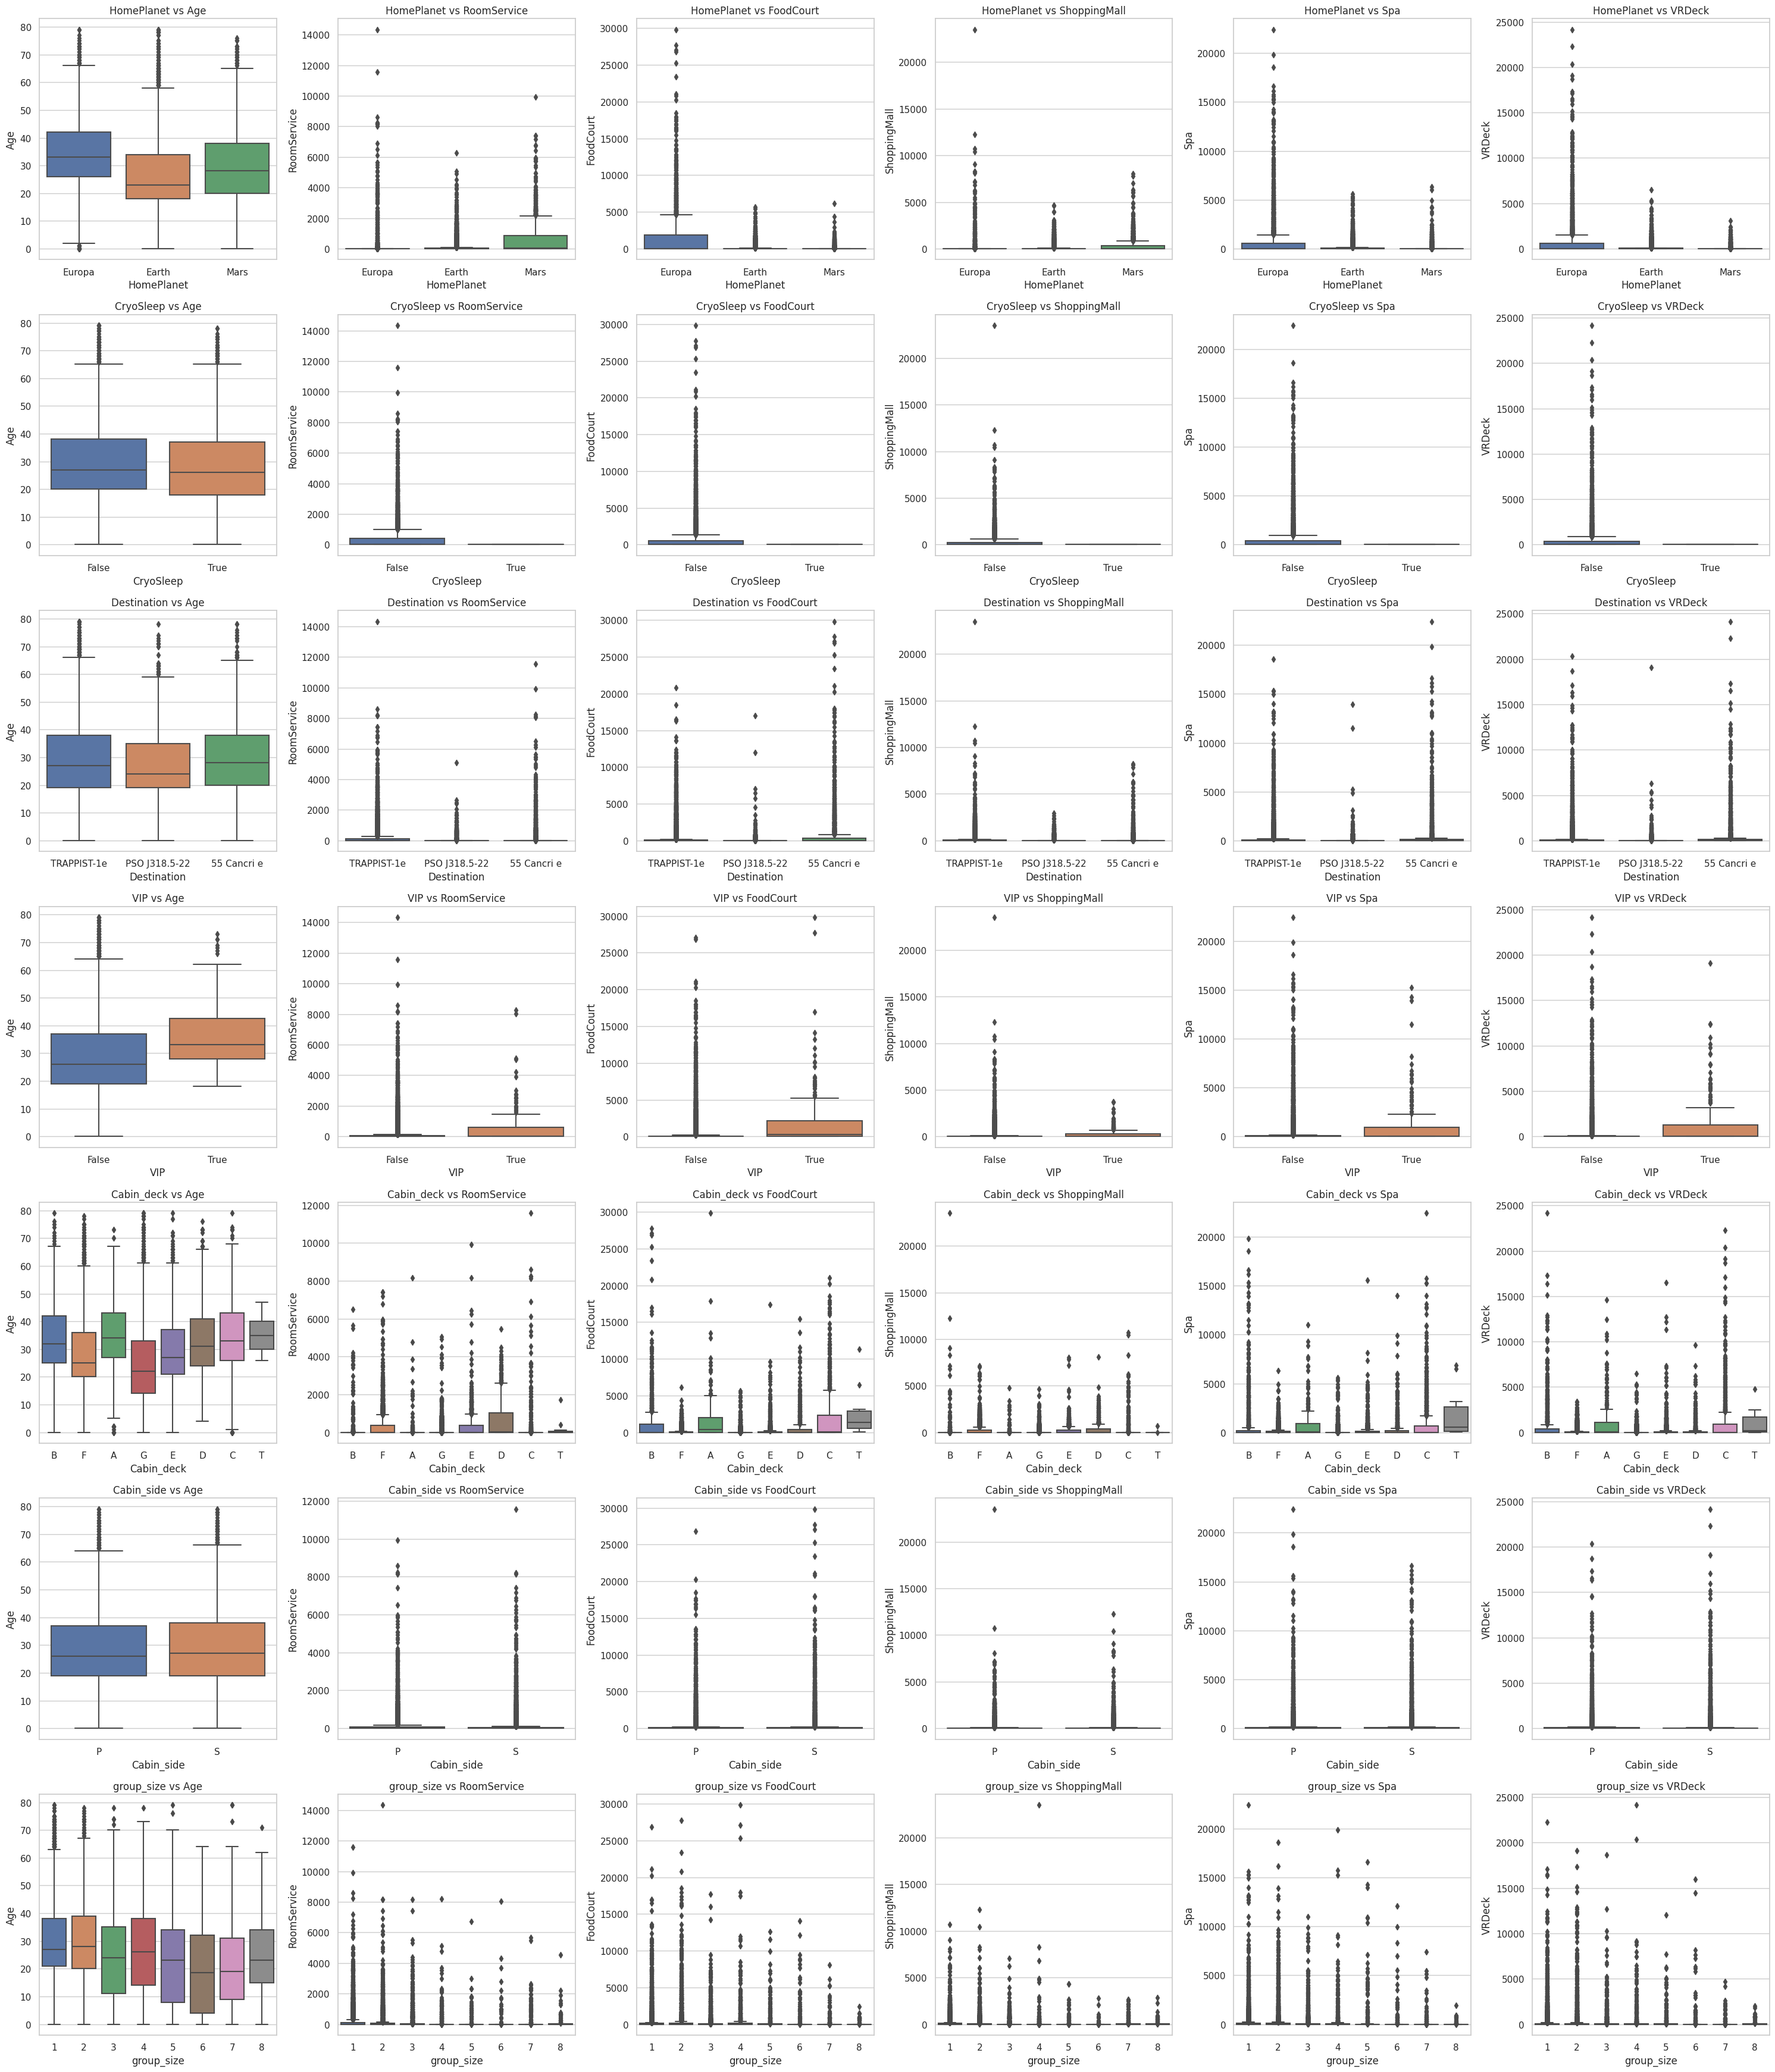

In [ ]:
fig, axes = plt.subplots(nrows=len(discrete_variables), ncols=len(continuous_variables), figsize=(30,35))

for i, variable_i in enumerate(discrete_variables):
  for j, variable_j in enumerate(continuous_variables):
    ax = sns.boxplot(x=variable_i, y=variable_j, data=df, ax=axes[i,j])
    axes[i, j].set_title(f'{variable_i} vs {variable_j}')

plt.tight_layout()
plt.show()

<ipython-input-68-5e3f3607a745>:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=np.log1p(df[variable_j]), hue=variable_i, multiple='stack', ax=axes[i, j])
<ipython-input-68-5e3f3607a745>:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=np.log1p(df[variable_j]), hue=variable_i, multiple='stack', ax=axes[i, j])
<ipython-input-68-5e3f3607a745>:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=np.log1p(df[variable_j]), hue=variable_i, multiple='stack', ax=axes[i, j])
<ipython-input-68-5e3f3607a745>:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=np.log1p(df[variable_j]), hue=variable_i, multiple='stack', ax=axes[i, 

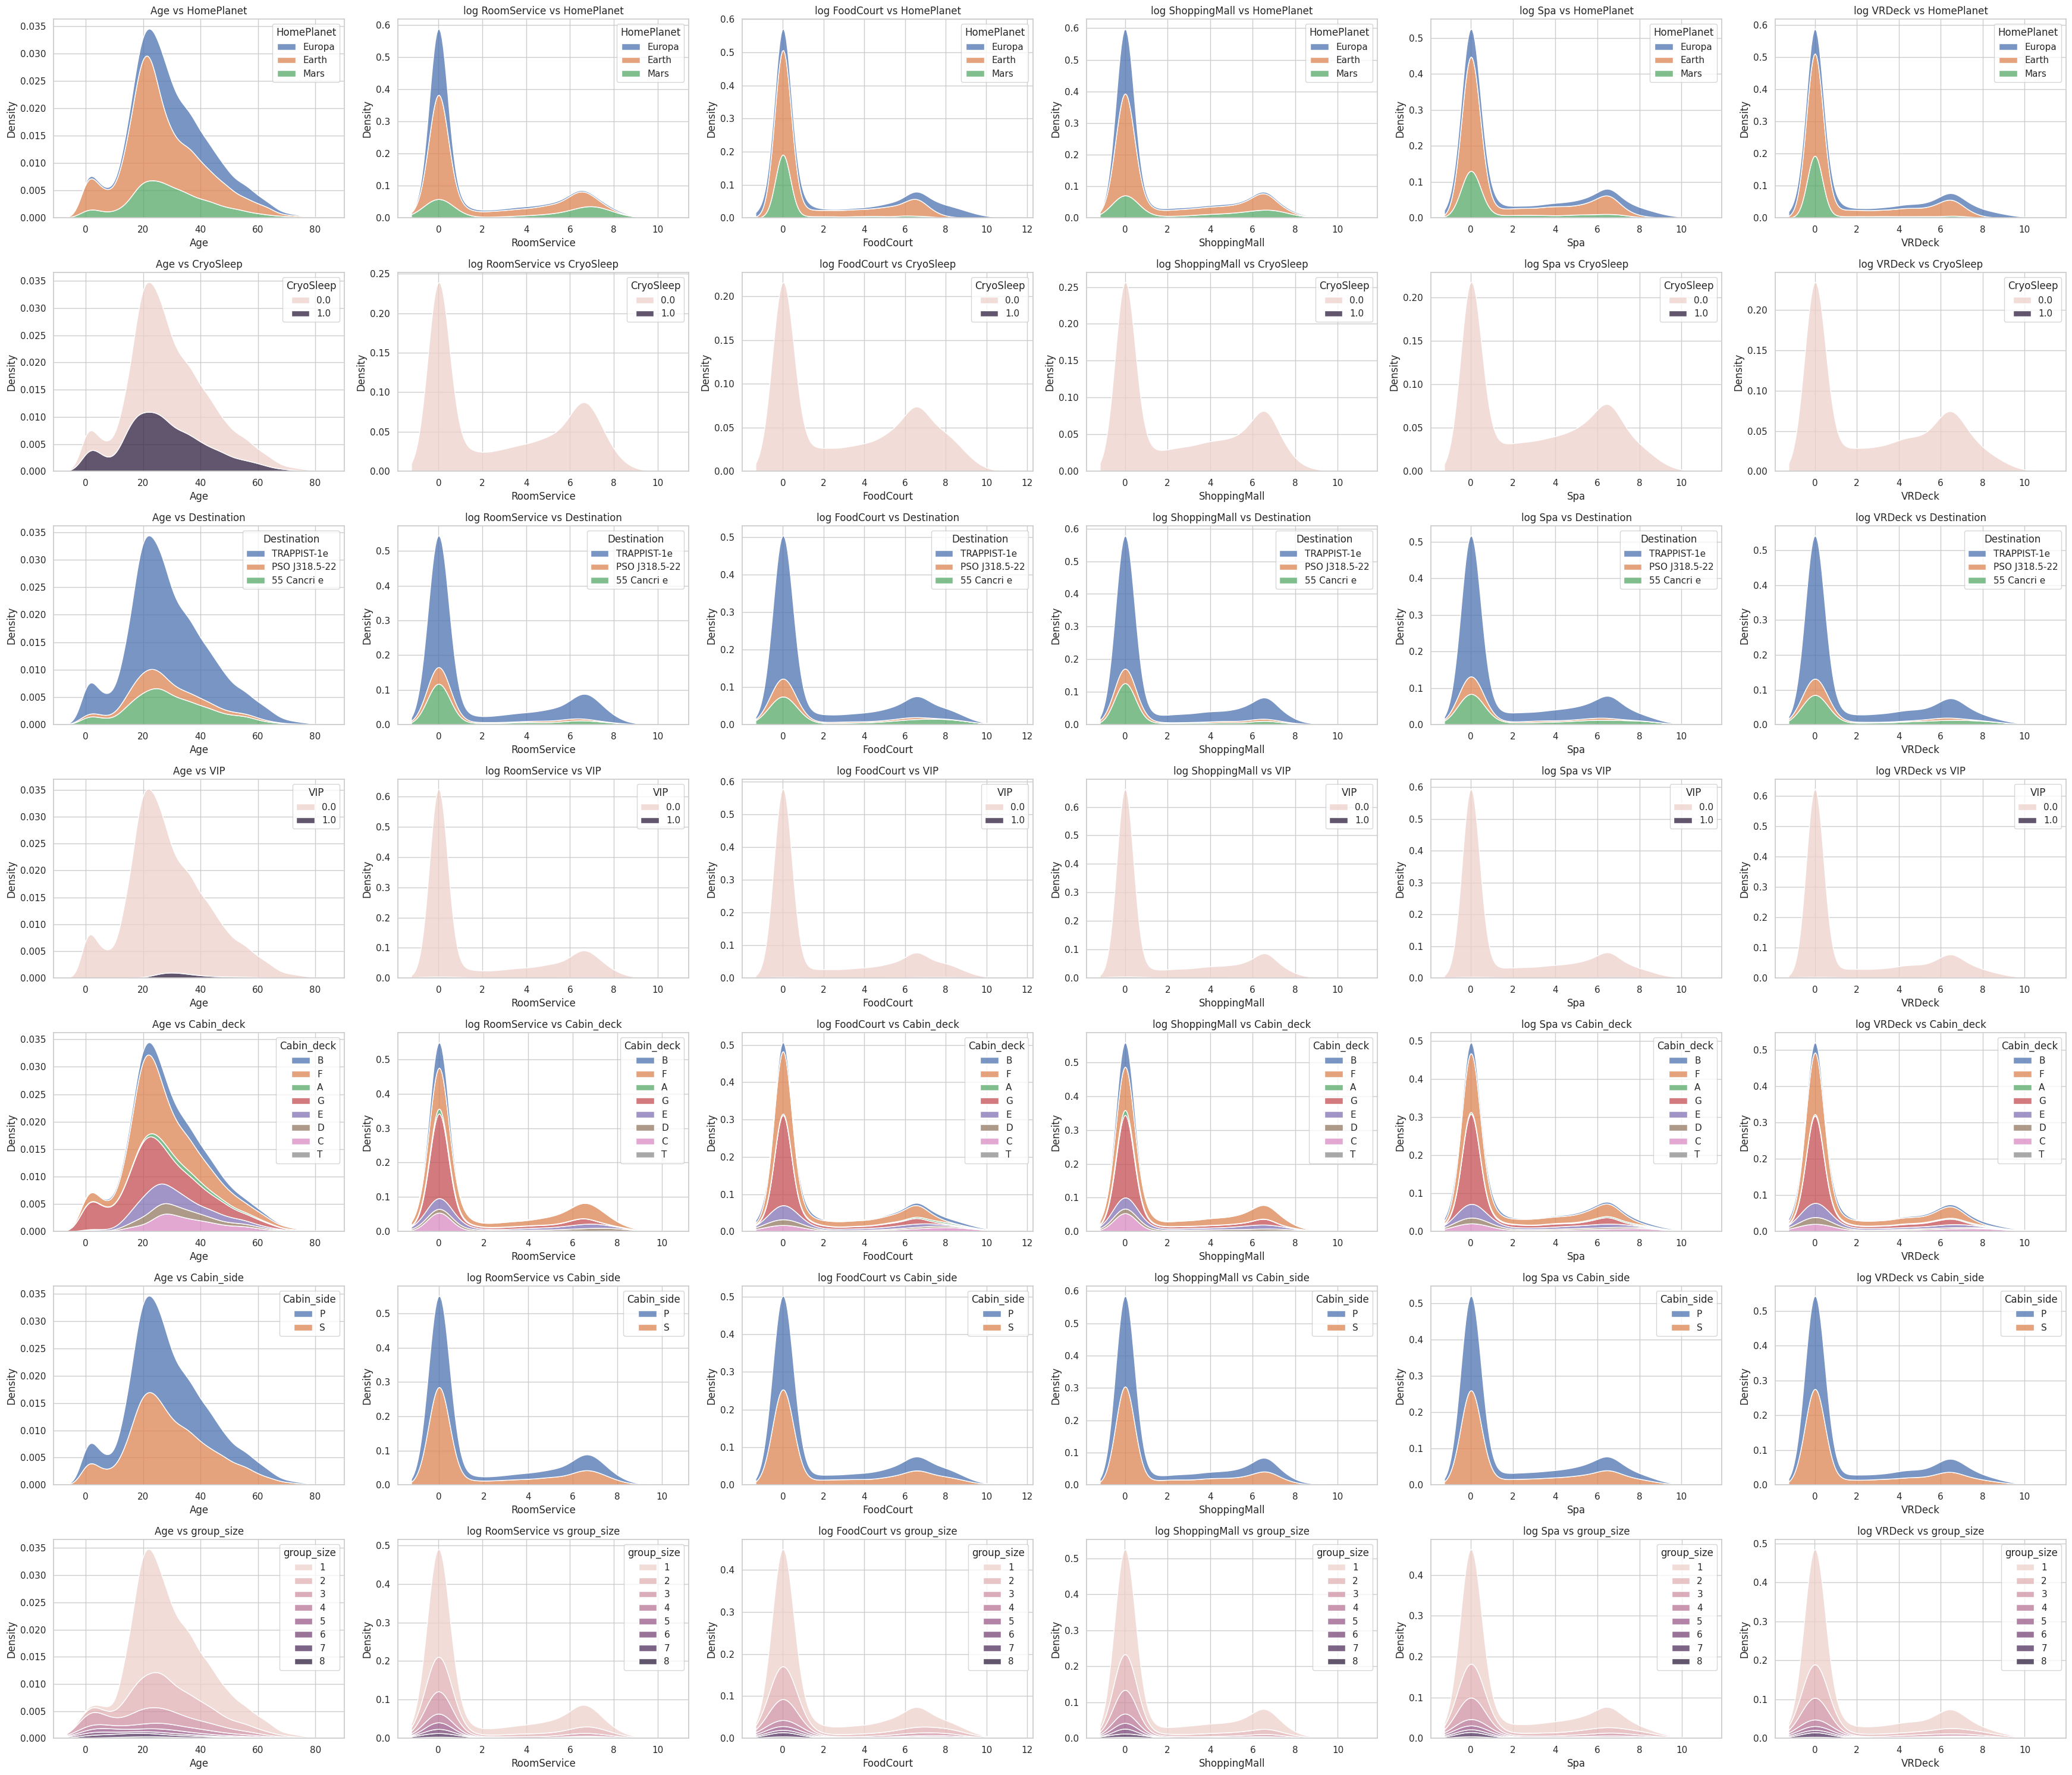

In [ ]:
# 原始資料因離群值太多導致pdf看不清楚，因此先取log再繪製kdeplot
fig, axes = plt.subplots(nrows=len(discrete_variables), ncols=len(continuous_variables), figsize=(35,30))

for i, variable_i in enumerate(discrete_variables):
  for j, variable_j in enumerate(continuous_variables):
    if variable_j != 'Age':
      sns.kdeplot(data=df, x=np.log1p(df[variable_j]), hue=variable_i, multiple='stack', ax=axes[i, j])
      axes[i, j].set_title(f'log {variable_j} vs {variable_i}')
    else:
      sns.kdeplot(data=df, x=variable_j, hue=variable_i, multiple='stack', ax=axes[i, j])
      axes[i, j].set_title(f'{variable_j} vs {variable_i}')

plt.tight_layout()
plt.show()

In [12]:
pd.DataFrame(df[continuous_variables+['set']].groupby(by=['set']).describe()).stack().unstack(0)

Age                RoomService                   FoodCourt  \
set           test        train          test         train          test   
count  4186.000000  8514.000000   4195.000000   8512.000000   4171.000000   
mean     28.658146    28.827930    219.266269    224.687617    439.484296   
std      14.179072    14.489021    607.011289    666.717663   1527.663045   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%      19.000000    19.000000      0.000000      0.000000      0.000000   
50%      26.000000    27.000000      0.000000      0.000000      0.000000   
75%      37.000000    38.000000     53.000000     47.000000     78.000000   
max      79.000000    79.000000  11567.000000  14327.000000  25273.000000   

                    ShoppingMall                         Spa                \
set           train         test         train          test         train   
count   8510.000000  4179.000000   8485.000000   4176.000000   8510.000000   
mean     458.077203   177.295525    173.729169    303.052443    311.138778   
std     1611.489240   560.821123    604.696458   1117.186015   1136.705535   
min        0.000000     0.000000      0.000000      0.000000      0.000000   
25%        0.000000     0.000000      0.000000      0.000000      0.000000   
50%        0.000000     0.000000      0.000000      0.000000      0.000000   
75%       76.000000    33.000000     27.000000     50.000000     59.000000   
max    29813.000000  8292.000000  23492.000000  19844.000000  22408.000000   

             VRDeck                
set            test         train  
count   4197.000000   8505.000000  
mean     310.710031    304.854791  
std     1246.994742   1145.717189  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%       36.000000     46.000000  
max    22272.000000  24133.000000

In [ ]:
pd.DataFrame(df[['Cabin_deck','Cabin_num']].dropna().groupby(by=['Cabin_deck']).describe()).stack().unstack(0)

Cabin_num                                                     \
Cabin_deck           A            B            C           D            E   
count       358.000000  1150.000000  1114.000000  722.000000  1328.000000   
mean         50.793296   162.688696   164.671454  141.645429   300.250753   
std          30.624623    97.255205    94.637682   83.296616   176.192737   
min           0.000000     0.000000     0.000000    0.000000     0.000000   
25%          23.000000    78.000000    83.000000   70.000000   146.750000   
50%          51.000000   165.000000   162.000000  138.000000   299.000000   
75%          76.000000   242.750000   244.750000  213.750000   454.000000   
max         109.000000   353.000000   342.000000  297.000000   608.000000   

                                                 
Cabin_deck            F            G          T  
count       4242.000000  3798.000000  11.000000  
mean         922.417492   754.679305   2.000000  
std          535.863433   433.758436   1.341641  
min            0.000000     0.000000   0.000000  
25%          457.250000   382.000000   1.000000  
50%          926.000000   753.000000   2.000000  
75%         1383.750000  1119.000000   3.000000  
max         1894.000000  1508.000000   4.000000

## 雙變數—與Transported有關

In [14]:
train_df = df[df['set']=='train'].drop(columns=['set'])
test_df = df[df['set']=='test'].drop(columns=['set', 'Transported'])

In [ ]:
train_df['Transported'].value_counts() # balance

True     4378
False    4315
Name: Transported, dtype: int64

### continuous variable

* 存在離群值，或許可嘗試將連續型資料分組、取log，或是選用較不受離群值影響的模型
* 消費金額對於是否 Transported 存在顯著差異

In [ ]:
pd.DataFrame(train_df[continuous_variables+['Transported']].groupby(by=['Transported']).describe()).stack().unstack(0) # 部分平均數有差異

Age                RoomService               \
Transported        False        True          False        True    
count        4226.000000  4288.000000   4217.000000  4295.000000   
mean           29.922858    27.748834    389.266066    63.098021   
std            13.699262    15.151705    875.638123   274.812497   
min             0.000000     0.000000      0.000000     0.000000   
25%            21.000000    18.000000      0.000000     0.000000   
50%            27.000000    26.000000      1.000000     0.000000   
75%            38.000000    37.000000    473.000000     0.000000   
max            79.000000    78.000000  14327.000000  3992.000000   

                FoodCourt                ShoppingMall                \
Transported         False         True          False         True    
count         4231.000000   4279.000000   4221.000000   4264.000000   
mean           382.615930    532.691984    167.566217    179.829972   
std           1200.115601   1931.306995    456.528126    722.026714   
min              0.000000      0.000000      0.000000      0.000000   
25%              0.000000      0.000000      0.000000      0.000000   
50%              0.000000      0.000000      0.000000      0.000000   
75%            179.000000      0.000000     95.000000      0.000000   
max          16856.000000  29813.000000  10705.000000  23492.000000   

                      Spa                     VRDeck               
Transported         False        True          False        True   
count         4223.000000  4287.000000   4225.000000  4280.000000  
mean           564.382666    61.675531    543.629822    69.148131  
std           1551.356047   262.682871   1563.088368   291.658171  
min              0.000000     0.000000      0.000000     0.000000  
25%              0.000000     0.000000      0.000000     0.000000  
50%              4.000000     0.000000      1.000000     0.000000  
75%            453.500000     0.000000    388.000000     0.000000  
max          22408.000000  4103.000000  24133.000000  5063.000000

In [ ]:
# 嘗試用t-test檢定差異
# （雖然從下圖觀察資料明顯不服從常態分配，但屬於大樣本，決定繼續使用此檢定）
temp_df = []
for col in continuous_variables:
  temp = train_df[[col]+['Transported']]
  stat, p = stats.ttest_ind(temp[(temp['Transported']==True) & ~(temp[col].isna())][col],
                            temp[(temp['Transported']==False) & ~(temp[col].isna())][col])
  temp_df.append([col, stat, p, p<0.05])

pd.DataFrame(temp_df, columns=['variables','statistic','p-value','significant'])
# 除了ShoppingMall外，其他變數在不同的Transported下都有顯著差異

variables  statistic        p-value  significant
0           Age  -6.941462   4.165051e-12         True
1   RoomService -23.403211  1.785674e-117         True
2     FoodCourt   4.119224   3.837181e-05         True
3  ShoppingMall   0.716634   4.736197e-01        False
4           Spa -21.045971   6.430493e-96         True
5        VRDeck -19.655873   3.585229e-84         True

In [ ]:
from scipy.stats import shapiro
from scipy.stats import lognorm

shapiro(train_df['Spa'])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=nan, pvalue=1.0)

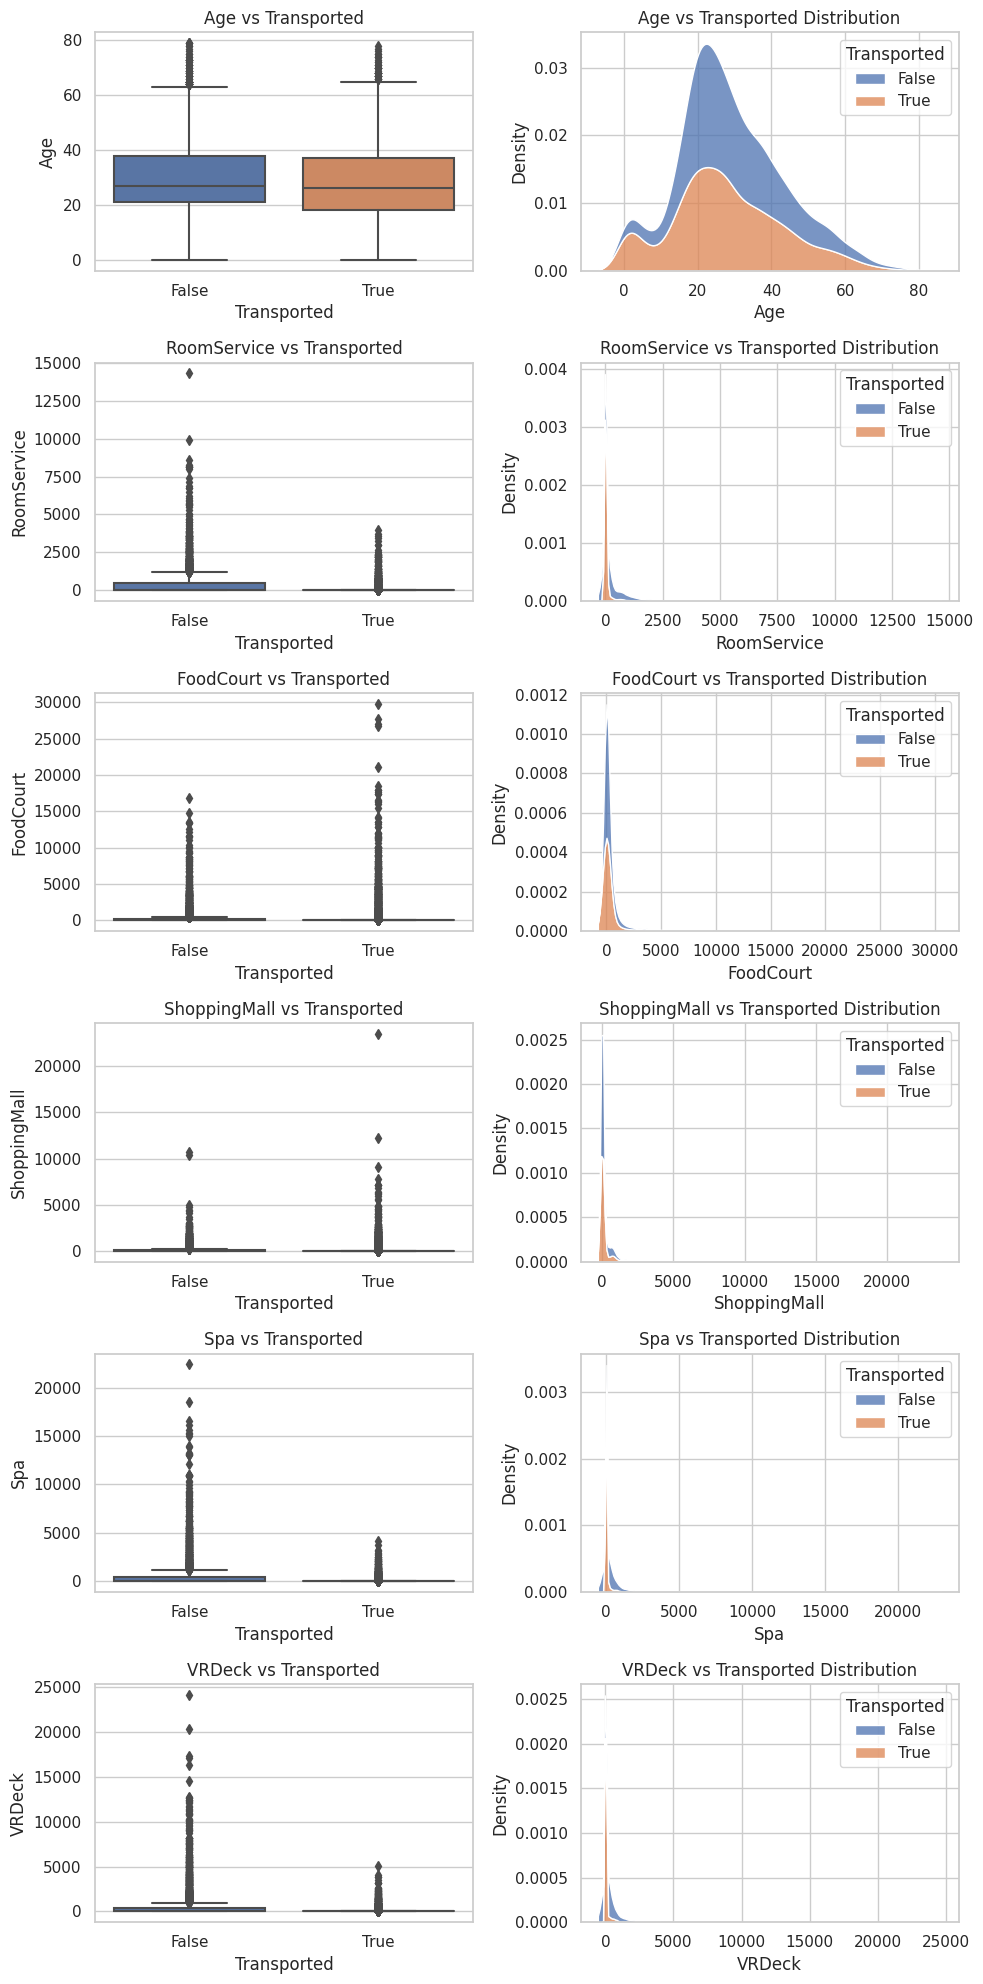

In [ ]:
# 原始資料
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=len(continuous_variables), ncols=2, figsize=(10, 20))

for i, variable in enumerate(continuous_variables):

    sns.boxplot(x='Transported', y=variable, data=train_df, ax=axes[i, 0])
    axes[i, 0].set_title(f'{variable} vs Transported')

    sns.kdeplot(data=train_df, x=variable, hue='Transported', multiple='stack', ax=axes[i, 1])
    axes[i, 1].set_title(f'{variable} vs Transported Distribution')

plt.tight_layout()
plt.show()

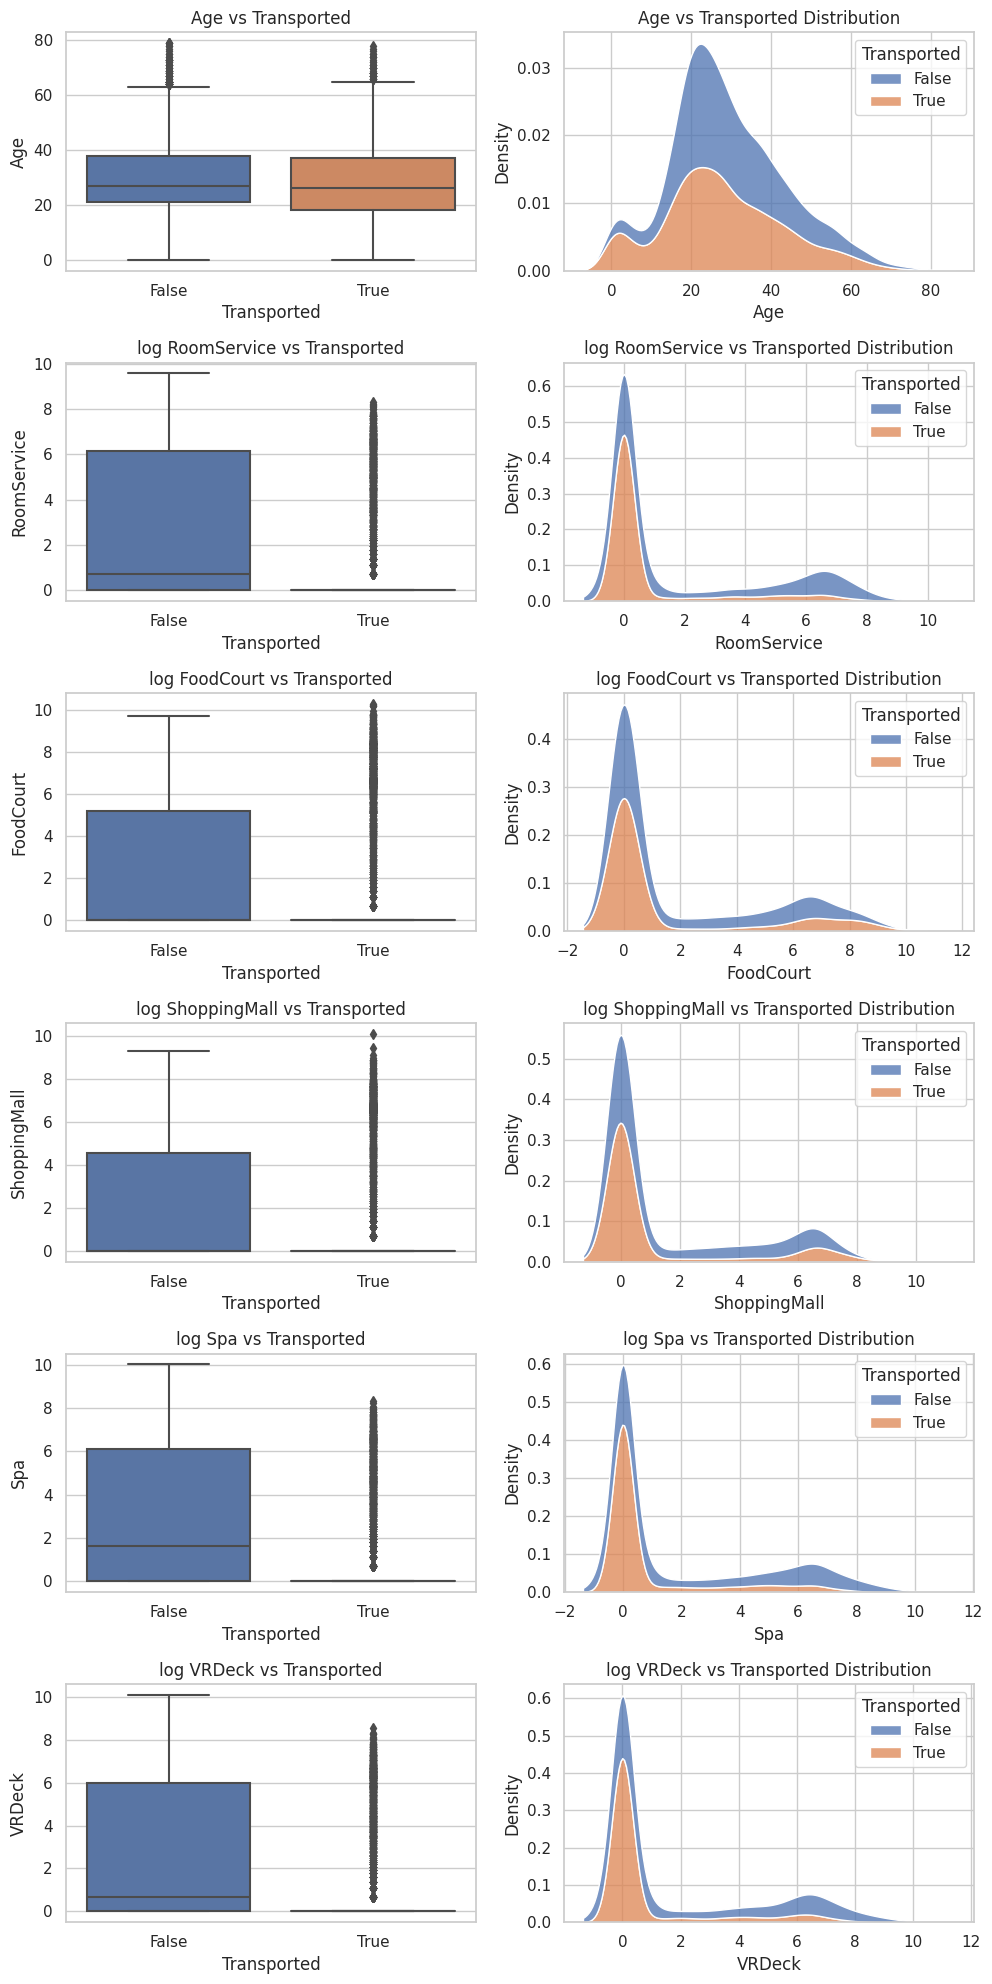

In [ ]:
# 做log轉換的資料
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=len(continuous_variables), ncols=2, figsize=(10, 20))

for i, variable in enumerate(continuous_variables):

  if variable=='Age':
    sns.boxplot(x='Transported', y=variable, data=train_df, ax=axes[i, 0])
    axes[i, 0].set_title(f'{variable} vs Transported')

    sns.kdeplot(data=train_df, x=variable, hue='Transported', multiple='stack', ax=axes[i, 1])
    axes[i, 1].set_title(f'{variable} vs Transported Distribution')

  else:
    sns.boxplot(x='Transported', y=np.log1p(train_df[variable]), data=train_df, ax=axes[i, 0])
    axes[i, 0].set_title(f'log {variable} vs Transported')

    sns.kdeplot(data=train_df, x=np.log1p(train_df[variable]), hue='Transported', multiple='stack', ax=axes[i, 1])
    axes[i, 1].set_title(f'log {variable} vs Transported Distribution')

plt.tight_layout()
plt.show()

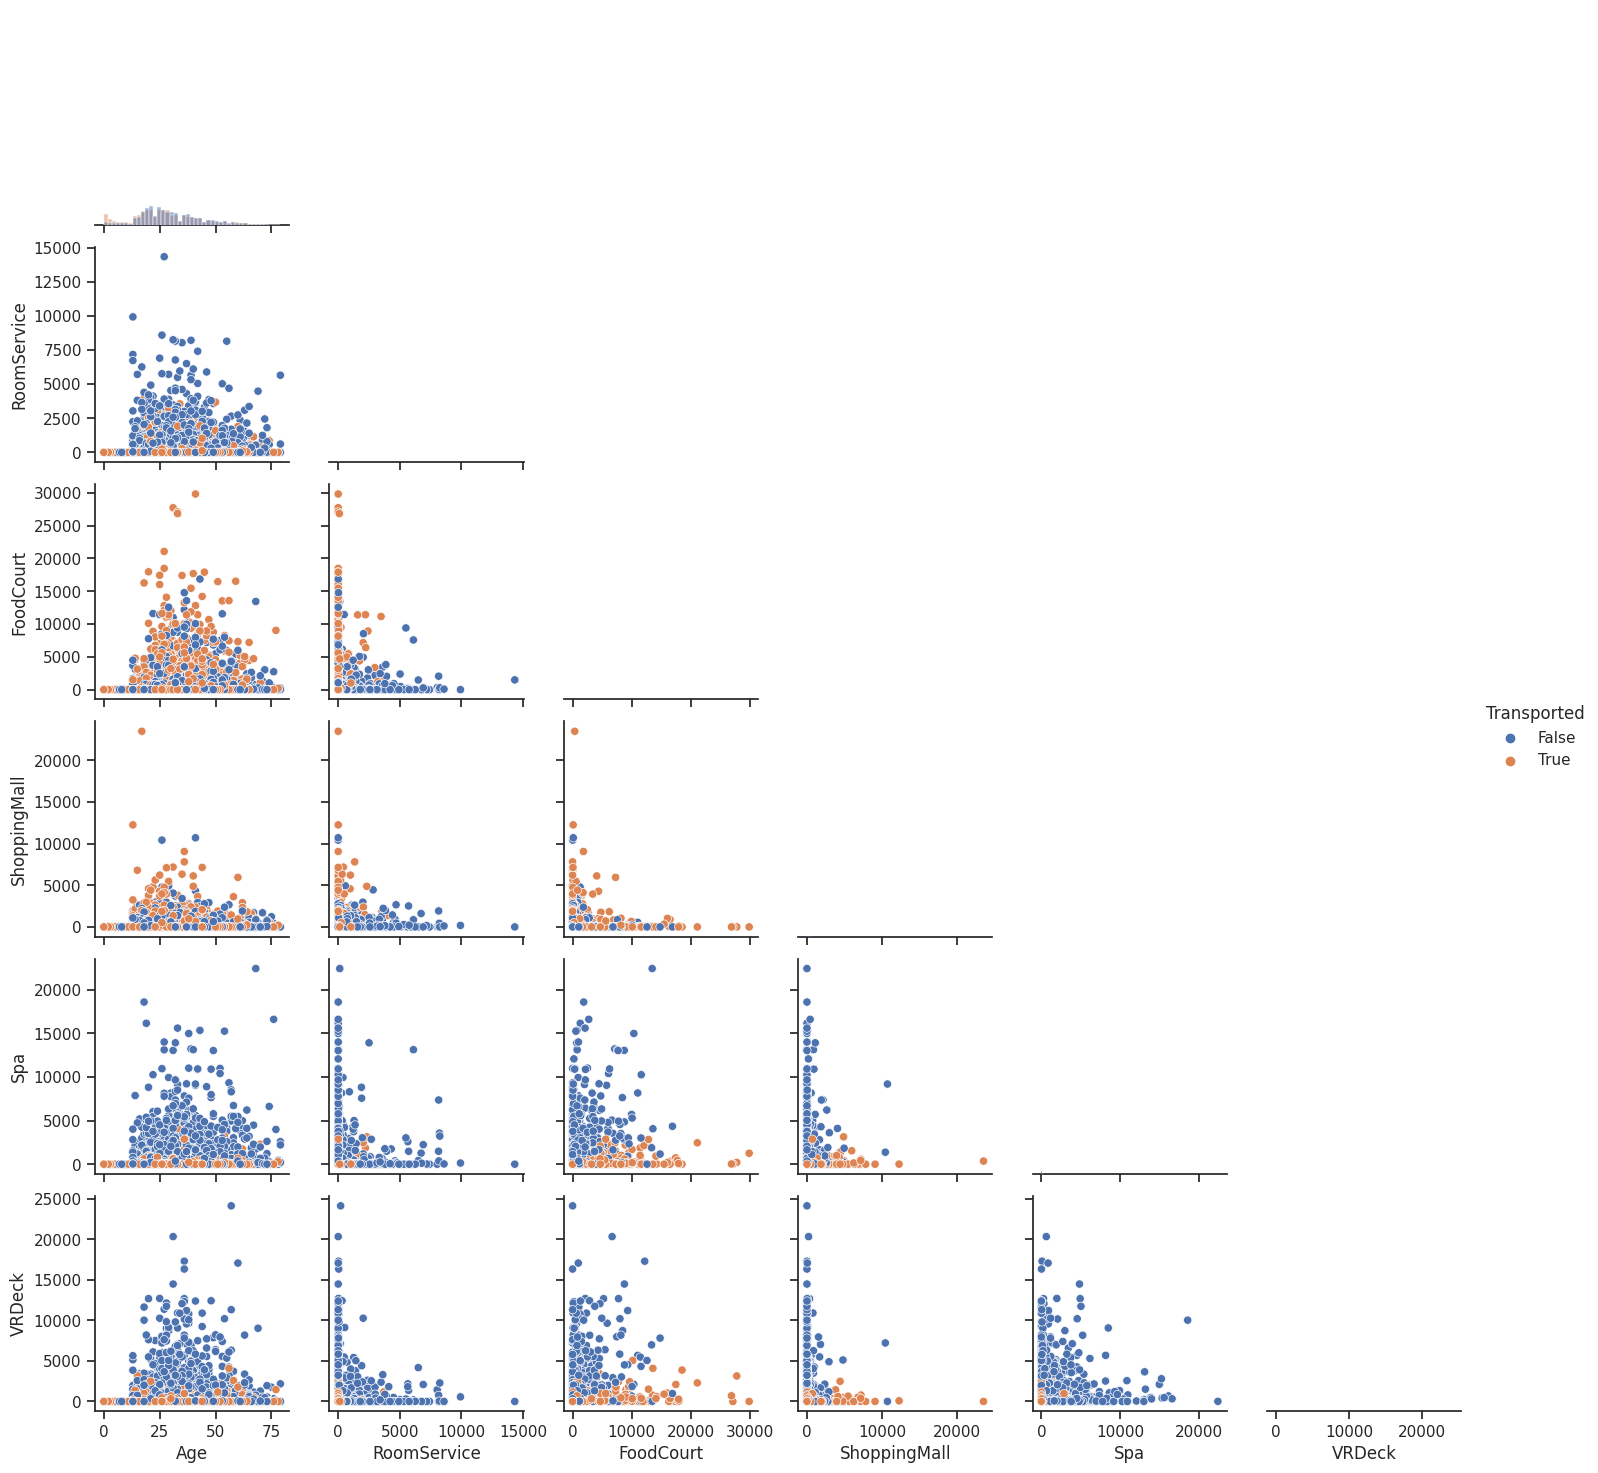

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(train_df[continuous_variables+['Transported']], corner=True, diag_kind="hist", hue="Transported")

###   discrete variable

* CryoSleep 對於 Transported 的影響蠻明顯的

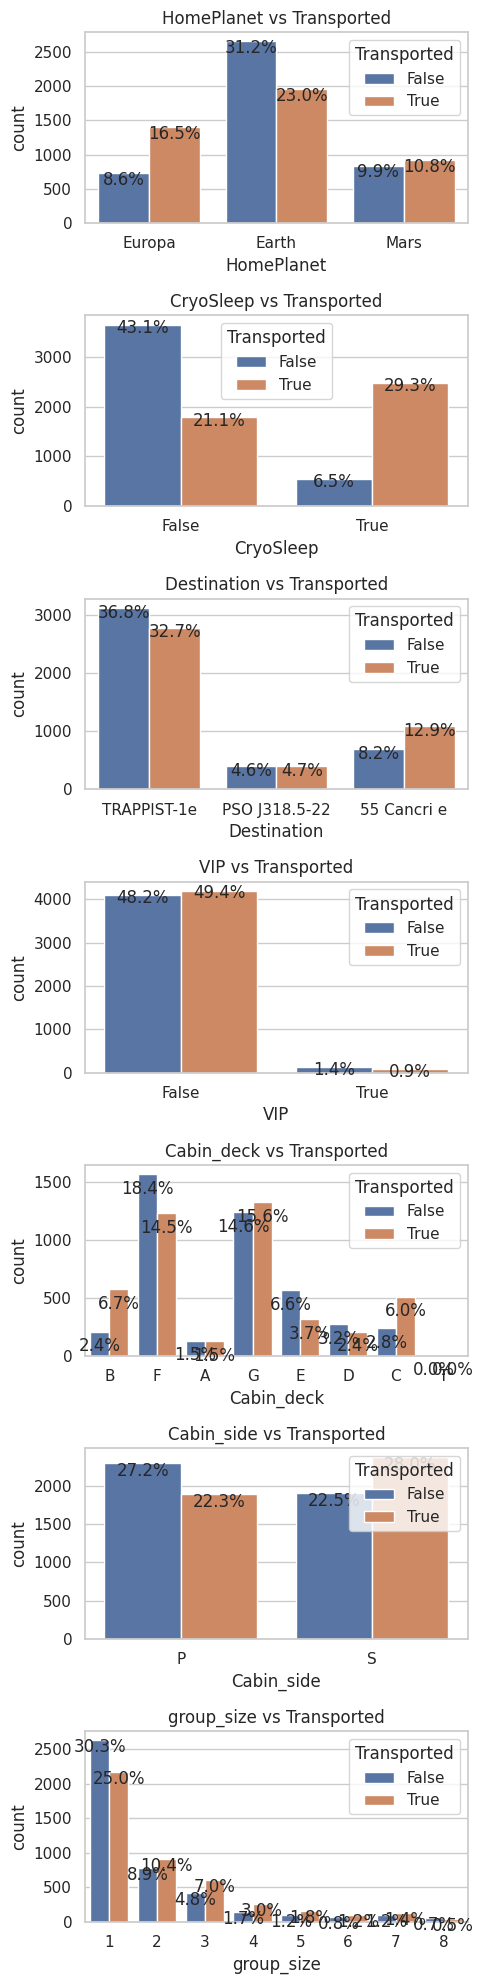

In [ ]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=len(discrete_variables), ncols=1, figsize=(5, 20))

for i, variable in enumerate(discrete_variables):
    ax = sns.countplot(x=variable, hue='Transported', data=train_df, ax=axes[i])
    axes[i].set_title(f'{variable} vs Transported')

    total = len(train_df[~train_df[variable].isna()][variable])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() - 0.02 * total
        ax.text(x, y, percentage, ha='center')

plt.tight_layout()
plt.show()

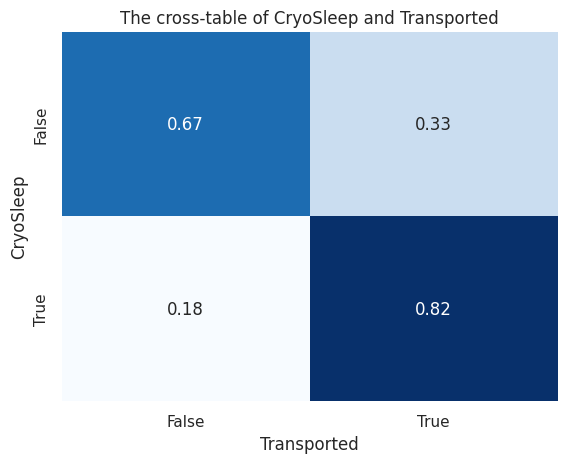

In [16]:
cross_tab = pd.crosstab(train_df['CryoSleep'], train_df['Transported'], normalize='index')

# 使用熱力圖顯示交叉表
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('The cross-table of CryoSleep and Transported')
plt.xlabel('Transported')
plt.ylabel('CryoSleep')

plt.show()

In [ ]:
for col in big_discrete_variables:
  print(train_df[[col]+['Transported']].groupby(col).value_counts(sort=False))

PassengerId_group  Transported
1                  False          1
2                  True           1
3                  False          2
4                  True           1
5                  True           1
                                 ..
9276               False          1
9278               False          1
9279               True           1
9280               False          1
                   True           1
Length: 7014, dtype: int64
Cabin_num  Transported
0.0        False          12
           True            6
1.0        False           5
           True           10
2.0        False           6
                          ..
1888.0     True            2
1891.0     True            1
1892.0     False           1
1893.0     True            1
1894.0     False           1
Length: 3030, dtype: int64
